This is an example of what we are doing with the ERT data, measured with the geoelectric measuring system Geophilus Electricus. Firstly, we have to do some computations. To do so, we should import required libraries:

In [2]:
import numpy as np
import utm
import geopandas as gpd
import fiona
import pandas as pd

In [3]:
filepath = 'TRB_Wertheim_Geophilus_roh_221125.csv'
farmName = 'Trebbin Wertheim'

EdecDeg, NdecDeg, H, Rho1, Rho2, Rho3, Rho4, Rho5, Rho6, Gamma, BFI, IfdNr, Date, time  \
    = np.genfromtxt(filepath, skip_header=1, delimiter=';', unpack=True)
dataRaw = np.genfromtxt(filepath, names=True, delimiter=';')
Eutm, Nutm, zone, letter  = utm.from_latlon(NdecDeg, EdecDeg) # convert E&N from DecimalDegree to UTM
data = np.column_stack((Eutm, Nutm, H, Rho1, Rho2, Rho3, Rho4, Rho6, Gamma,))
np.savetxt(f'{farmName} farm_data.csv', data, delimiter=';', fmt='%s')

In [4]:
kmlFile = "TRB_Wertheim_Referenzpunkte_gemessen_2022-12-01.kml"
fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdf = gpd.read_file(kmlFile) #GeoDataFrame object (ref names & geometry,in decimaldegree)
refLat = np.array(gdf['geometry'].y)
refLon = np.array(gdf['geometry'].x)
refEutm, refNutm, refzone, refletter  = utm.from_latlon(refLat, refLon) # convert E&N from DecimalDegree to UTM
refName = np.array(gdf['Name'])
refPoints = np.column_stack([refName, refEutm, refNutm])# RefPointNames+geometry,in lat/long
header = ['Name', 'E', 'N']
refPointsTable = np.vstack((header, refPoints))
np.savetxt(f'{farmName} farm_refPoints.csv', refPointsTable, delimiter=';', fmt='%s')

In [5]:
refName = np.array(gdf['Name'])
meanDataVal =[]
refpoints = f'{farmName} farm_refPoints.csv'
RefPoints = pd.read_csv(refpoints, delimiter=";")

for point in refPoints:
    array = data
    dist = np.sqrt((array[:,0]-point[1])**2+(array[:,1]-point[2])**2)
    # distToRef = 8
    # nearestArray = np.nonzero(dist<distToRef)[0] # return indices of the elements that are non-zero
    dist_index = np.argmin(dist)
    nearestArray = np.arange(dist_index-5, dist_index+5)
    # npoints = 5
    # nearestArayRow = np.argsort(np.abs(nearestArray - np.mean(nearestArray)))[:npoints]
    
    dataNearest = data[nearestArray]   # data of individual closest points
    
    MeanOfNearestPoints = np.column_stack((np.mean(Eutm[nearestArray]), np.mean(Nutm[nearestArray]), \
                              np.mean(Rho1[nearestArray]), np.mean(Rho2[nearestArray]), \
                              np.mean(Rho3[nearestArray]), np.mean(Rho4[nearestArray]), \
                              np.mean(Rho6[nearestArray]), 
                              np.mean(Gamma[nearestArray])))        
    meanDataVal.append(MeanOfNearestPoints)
    meanDataArray = np.array(meanDataVal)
    meanDataNearestVector = np.array((meanDataArray[:,0,:])) # mean data of closest points
np.savetxt(f'{farmName}-meanNearestPoints.csv', meanDataNearestVector, delimiter=';')
np.savetxt(f'{farmName}-nearestArray.csv', dataNearest, delimiter=',', fmt='%s')

# %% 

In [7]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import pygimli as pg
import skgstat as skg

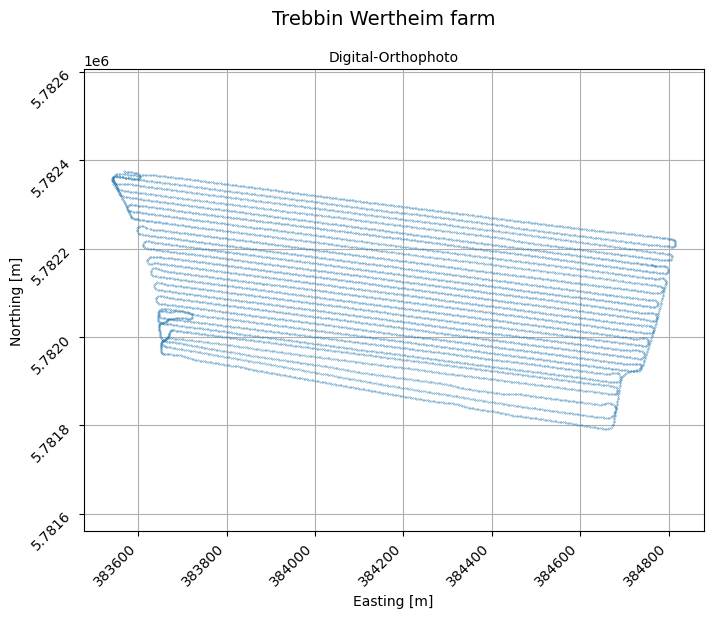

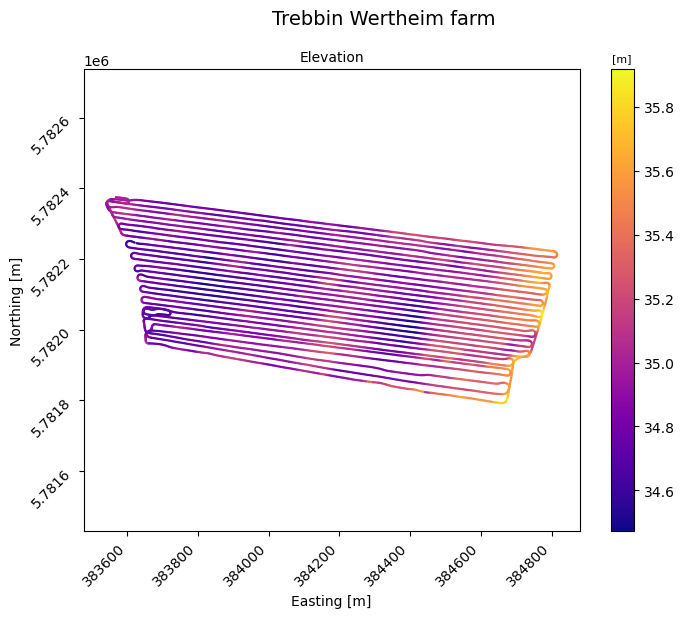

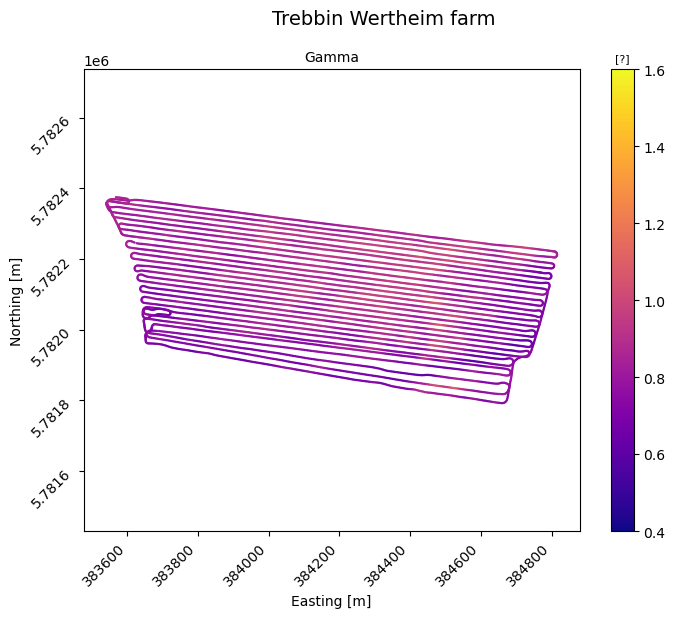

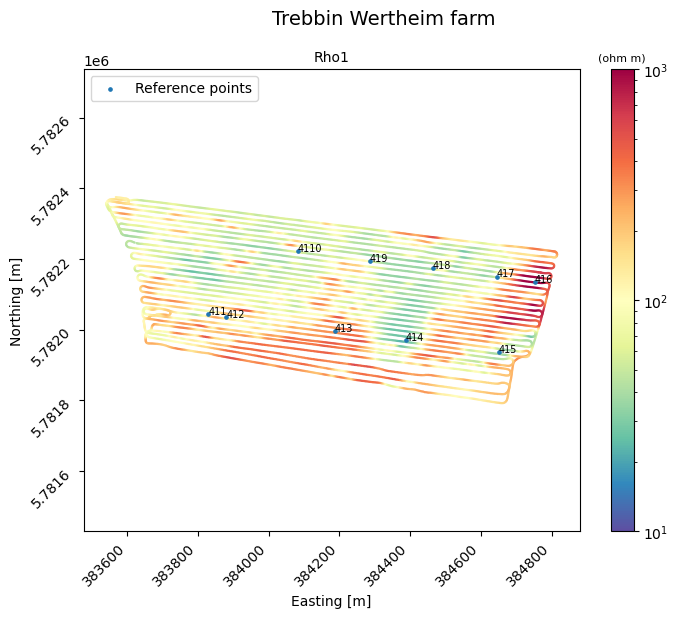

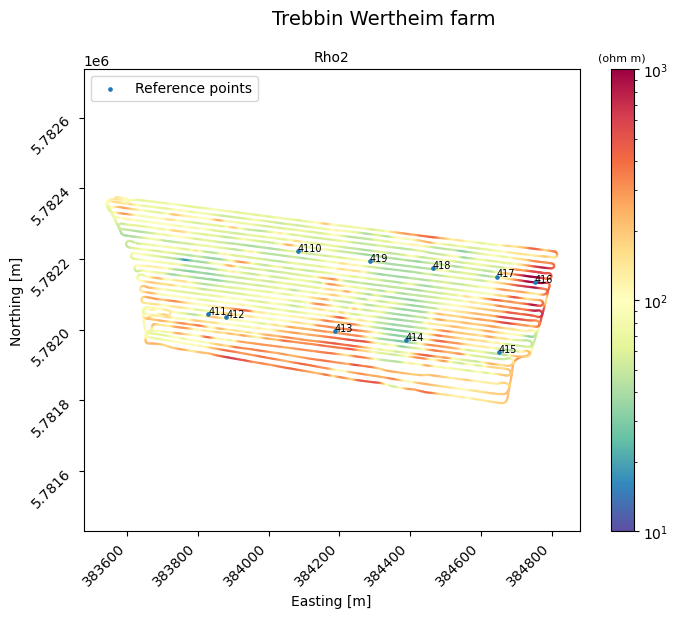

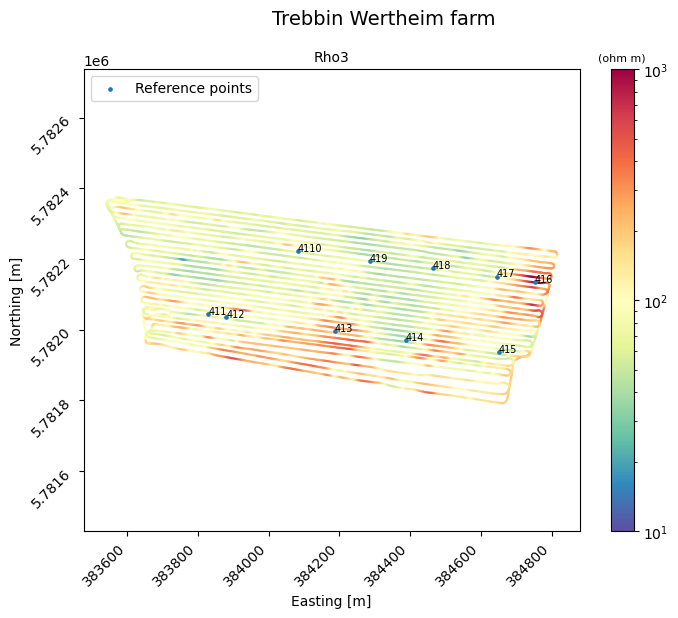

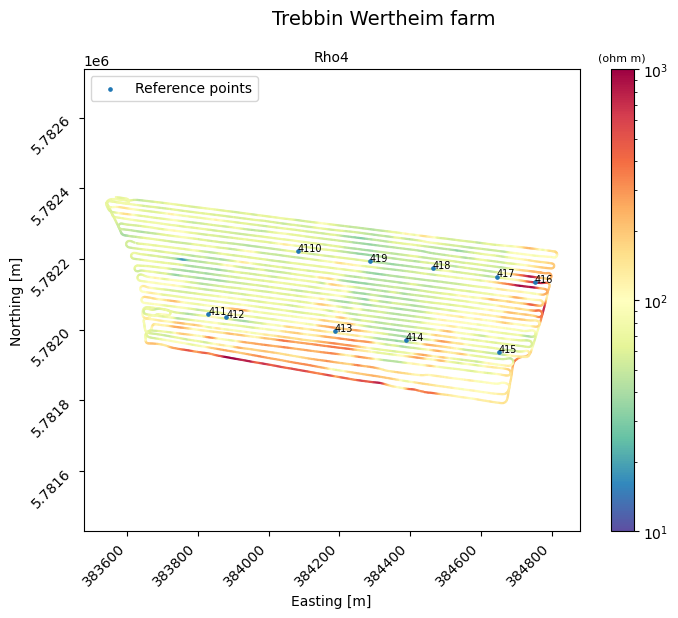

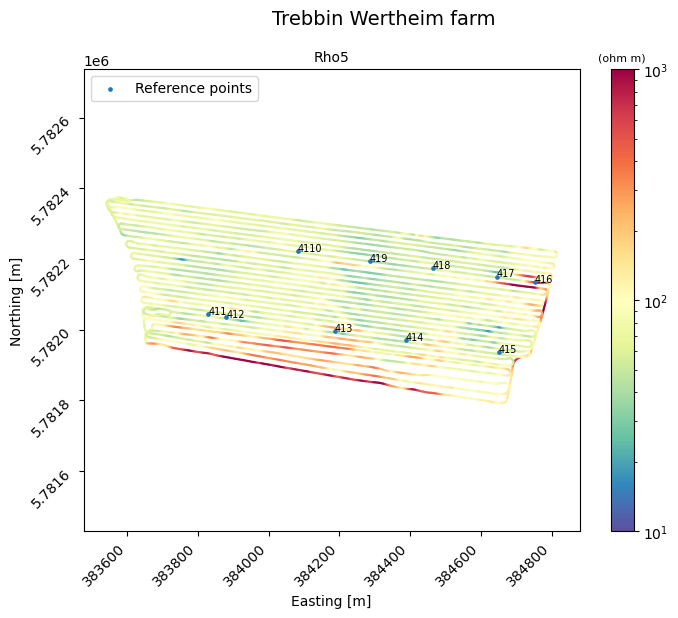

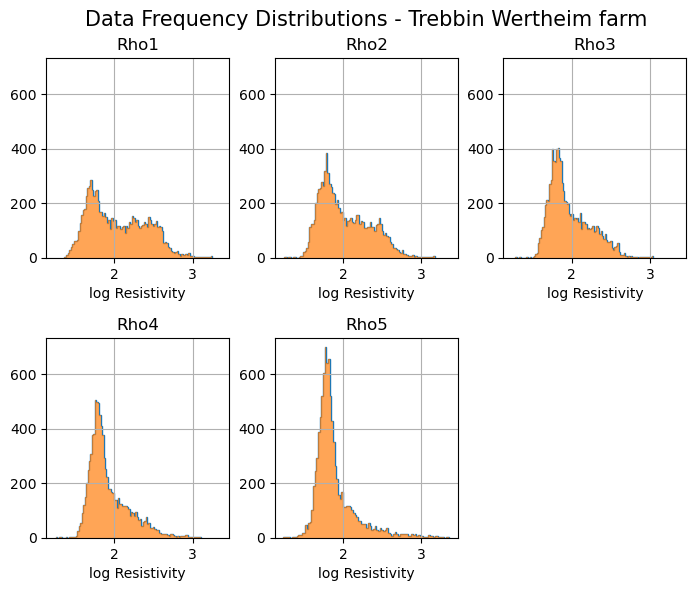

In [8]:
filepath = 'TRB_Wertheim_Geophilus_roh_221125.csv'
farmName = 'Trebbin Wertheim'

data = np.loadtxt(f'{farmName} farm_data.csv', delimiter=';')
Eutm, Nutm, H, Gamma = data[:,0] , data[:,1], data[:,2], data[:,8]
Rho1, Rho2, Rho3, Rho4, Rho6 = data[:, 3],data[:, 4],data[:, 5],data[:, 6],data[:, 7]
refPoints = pd.read_csv(f'{farmName} farm_refPoints.csv', delimiter=';')
refEutm, refNutm = refPoints['E'] , refPoints['N']
RhoData = data[:, 3:8]

with PdfPages(f'{farmName} mapped-data-multipage_pdf_.pdf') as pdf:
    # Orthophoto map
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(Eutm, Nutm, ".", markersize=0.5)
    ax.set_aspect(1.0)
    ax.grid()
    plt.title('Digital-Orthophoto', fontsize=10)
    plt.suptitle(f'{farmName} farm', fontsize=14)
    plt.xlabel('Easting [m]')
    plt.ylabel('Northing [m]')
    plt.yticks(rotation=45, ha='right')
    plt.xticks(rotation=45, ha='right')
    plt.axis("equal")
    # pg.viewer.mpl.underlayBKGMap(ax, mode='DOP', utmzone=33, epsg=0, uuid='8102b4d5-7fdb-a6a0-d710-890a1caab5c3', usetls=False, origin=None) 
    plt.savefig(pdf, format='pdf') 
            
    # Elevation  map
    fig=plt.figure(figsize=(8, 6))      
    ax2 = plt.scatter(Eutm, Nutm, s=0.5, c=H, cmap='plasma', vmin=np.min(H), vmax=np.max(H))
    clb = plt.colorbar(ax2)
    clb.ax.set_title('[m]',fontsize=8)
    plt.axis("equal")
    plt.title('Elevation', fontsize=10)
    plt.suptitle(f'{farmName} farm', fontsize=14)
    plt.xlabel('Easting [m]')
    plt.ylabel('Northing [m]')
    plt.yticks(rotation=45, ha='right')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(pdf, format='pdf') 
    
    # Gamma map
    fig=plt.figure(figsize=(8, 6))      
    ax2 = plt.scatter(Eutm, Nutm, s=0.5, c=Gamma, cmap='plasma', vmin=0.4, vmax=1.6)
    clb = plt.colorbar(ax2)
    clb.ax.set_title('[?]',fontsize=8)
    plt.axis("equal")
    plt.title('Gamma', fontsize=10)
    plt.suptitle(f'{farmName} farm', fontsize=14)
    plt.xlabel('Easting [m]')
    plt.ylabel('Northing [m]')
    plt.xticks(rotation=45, ha='right')    
    plt.yticks(rotation=45, ha='right')
    plt.savefig(pdf, format='pdf')     
    
    # Rho maps
    for col in range(RhoData.shape[1]):
        Rho_i = col+1
        Rhoi =RhoData[:,col]
        norm = matplotlib.colors.LogNorm(vmin=10, vmax=1000, clip=False)
        fig=plt.figure(figsize=(8, 6))
        ax1 = plt.scatter(Eutm, Nutm, s=0.5, c=RhoData[:,col], cmap='Spectral_r', norm=norm)
        clb = fig.colorbar(ax1)
        clb.ax.set_title('(ohm m)',fontsize=8)
        plt.axis("equal")
        plt.title(f'Rho{Rho_i}', fontsize=10)
        plt.suptitle(f'{farmName} farm', fontsize=14)
        plt.xlabel('Easting [m]')
        plt.ylabel('Northing [m]')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45, ha='right')
        ax2 = plt.scatter(refEutm, refNutm, s=5.5, label="Reference points") #Ref Points
        refName = refPoints['Name'].astype(int) # refPoint names
        for i, txt in enumerate(refName):
            plt.annotate(txt, (refEutm[i], refNutm[i]), fontsize=7)
            plt.legend(loc="upper left")
        plt.savefig(pdf, format='pdf')   
    
    # histogram of data distribution (log)
    RhoData = np.column_stack((Rho1, Rho2, Rho3, Rho4, Rho6))
    num_bins = 100
    fig=plt.figure(figsize=(8, 6))
    c = 1  # initialize plot counter
    for cols in range(RhoData.shape[1]):
        Rho_i = cols+1
        Rhoi =RhoData[:,cols]
        ax1 = plt.subplot(2, 3, 1)
        ax2 = plt.subplot(2, 3, c, sharex=ax1, sharey=ax1)
        counts, bins = np.histogram(np.log10(RhoData[:,cols]), bins=num_bins)
        ax3 = plt.stairs(counts, bins)
        ax4 = plt.hist(bins[:-1], bins, weights=counts, alpha=0.7)
        plt.suptitle(f'Data Frequency Distributions - {farmName} farm', fontsize=15, y=0.98)
        plt.title(f'Rho{Rho_i}', fontsize=12)
        plt.xlabel('log Resistivity')
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.25, hspace=0.4)
        plt.grid()
        c=c+1

    plt.savefig(pdf, format='pdf')   

In [9]:
# %% Find nearest dataPoints to refPoints
meanDataVal =[]
refpoints = f'{farmName} farm_refPoints.csv'
RefPoints = pd.read_csv(refpoints, delimiter=";")

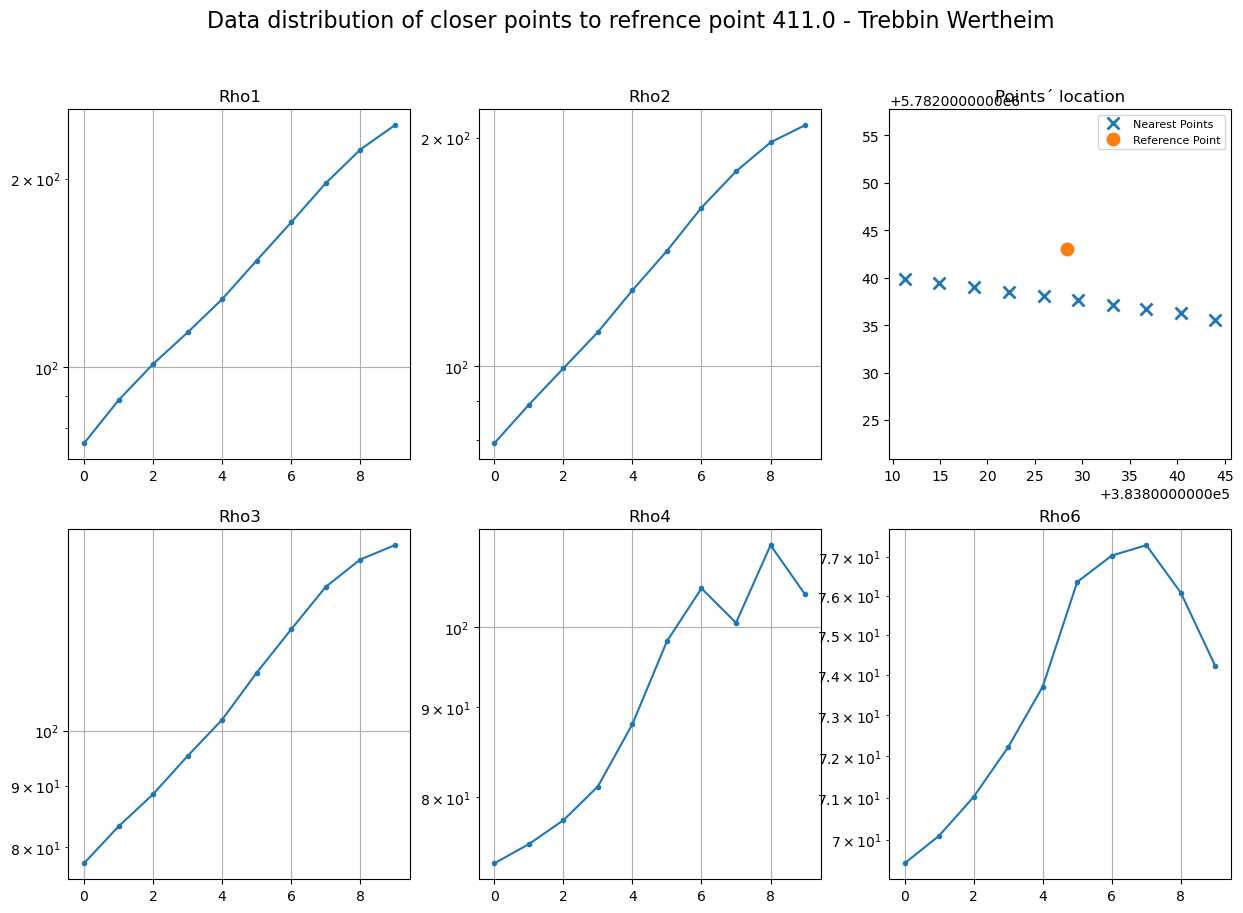

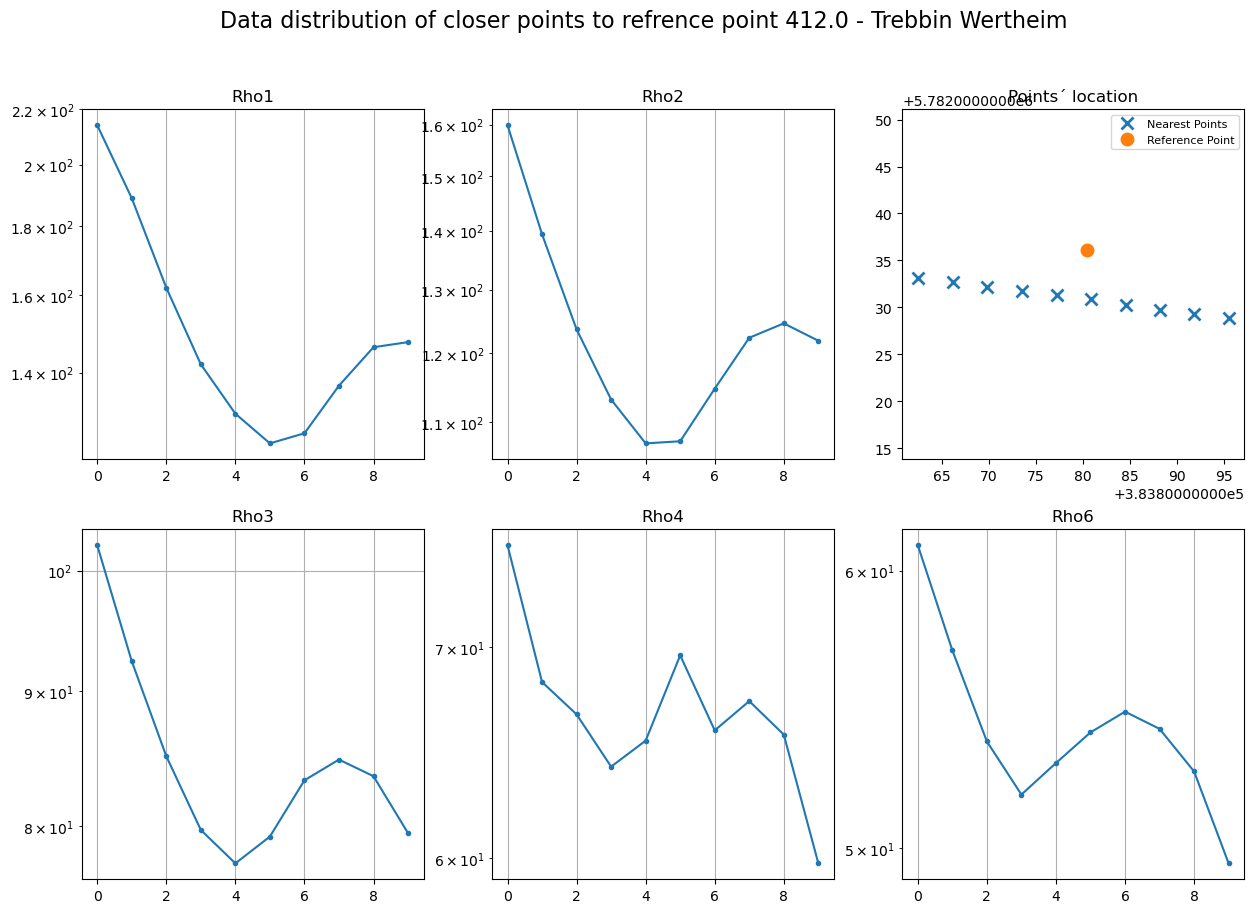

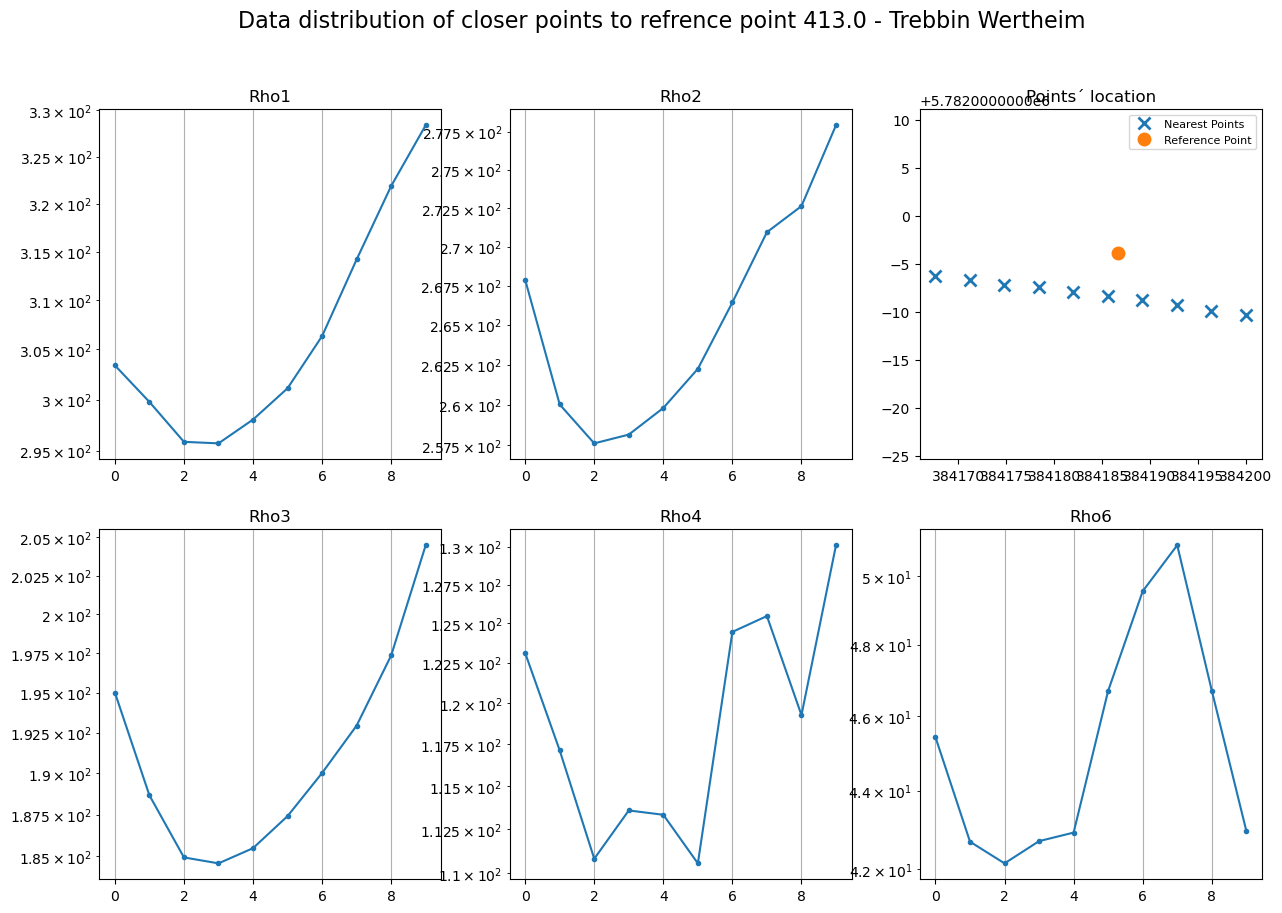

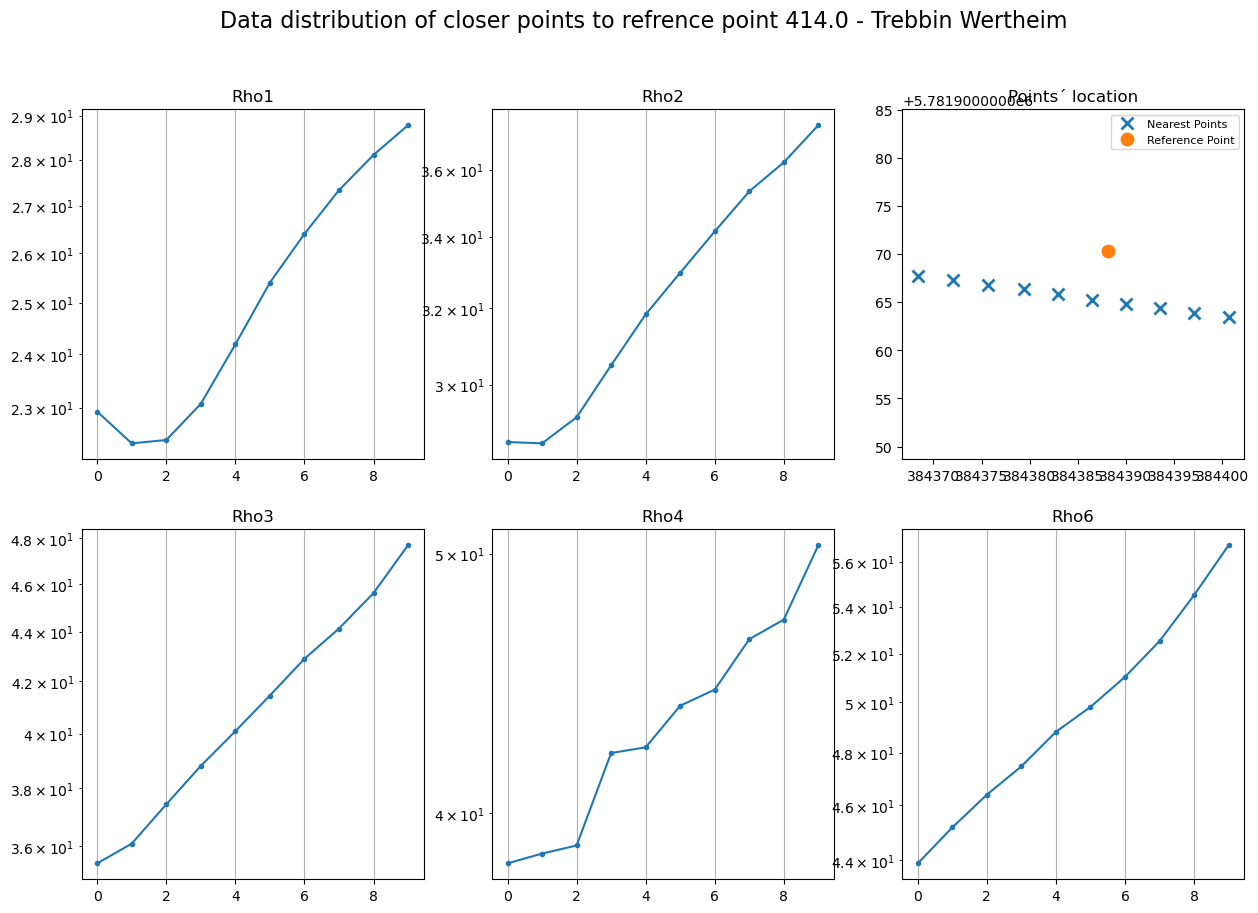

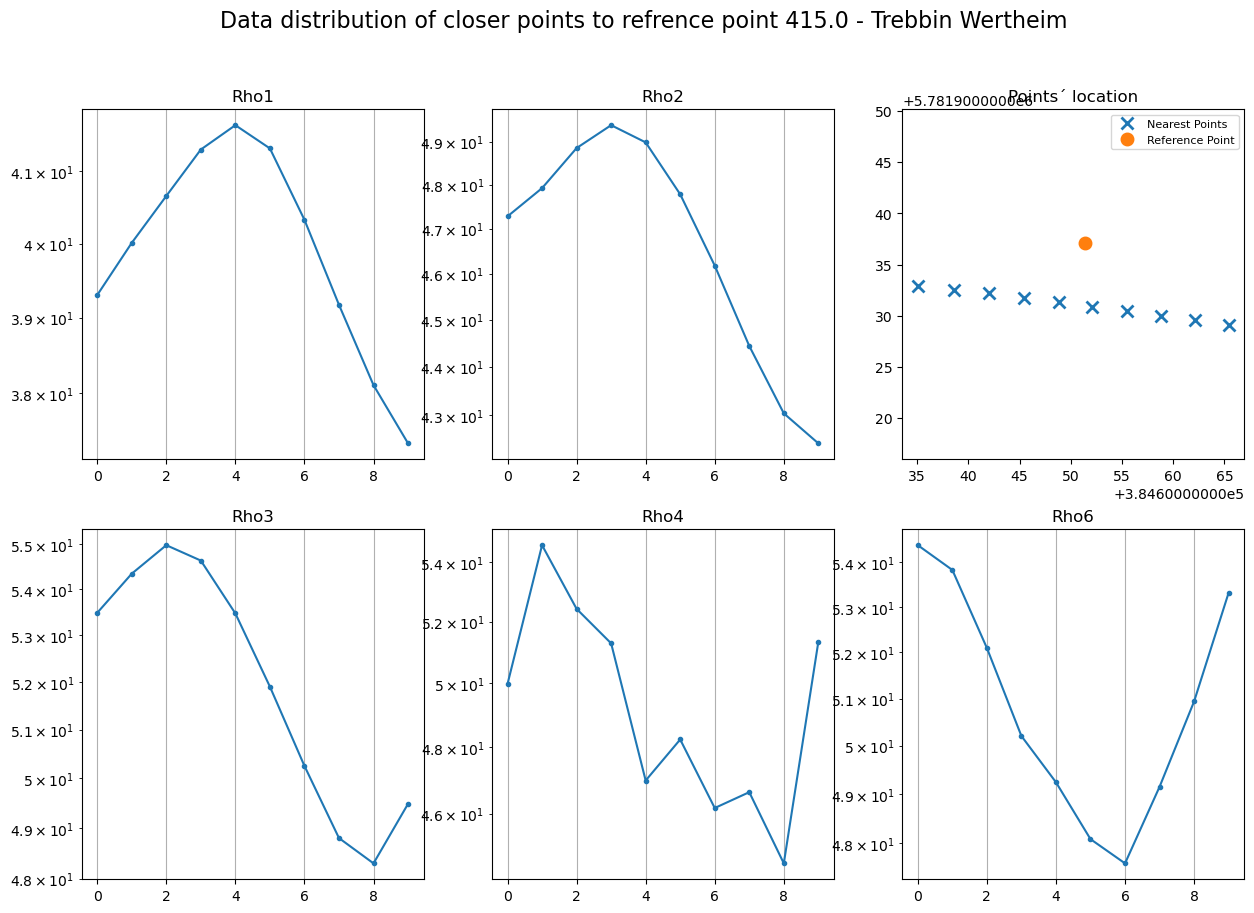

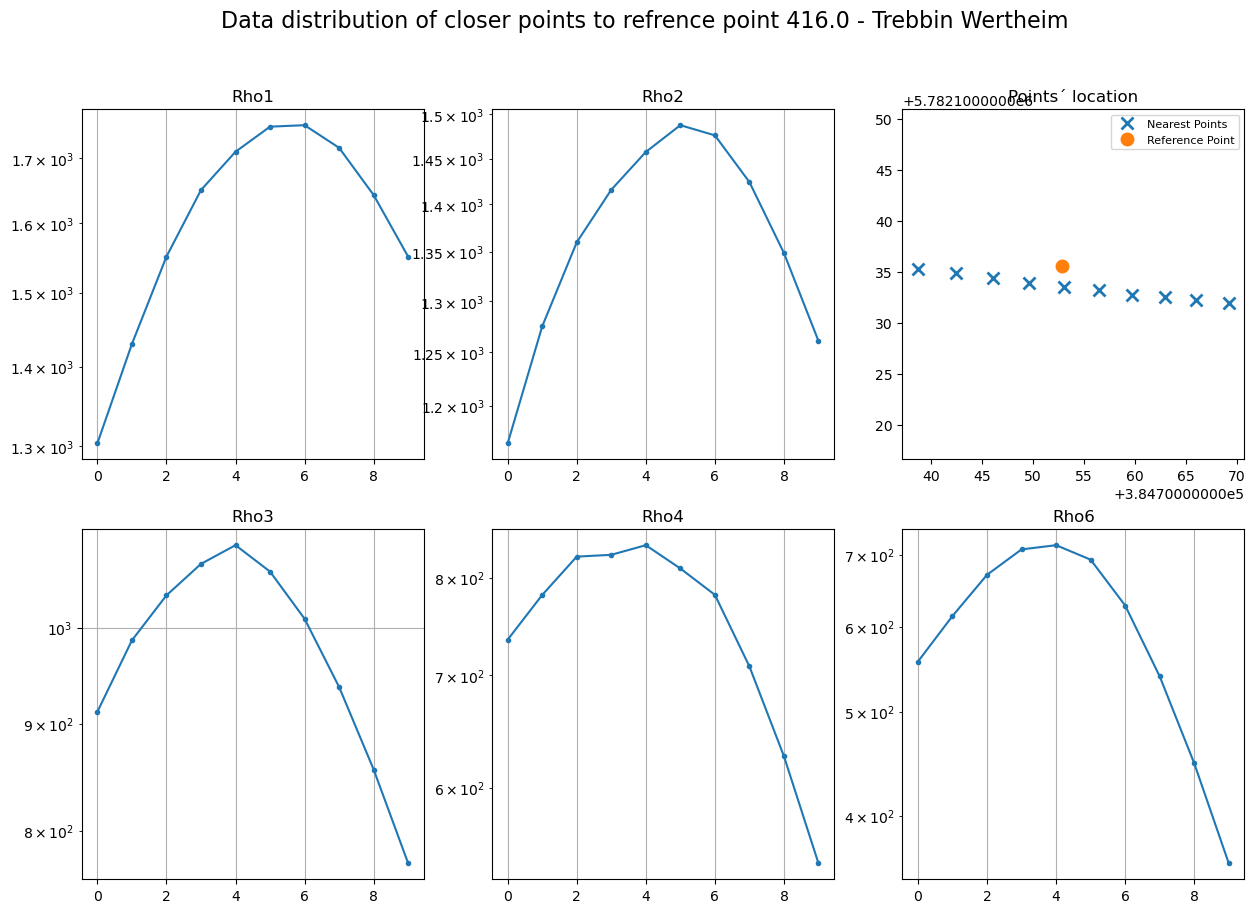

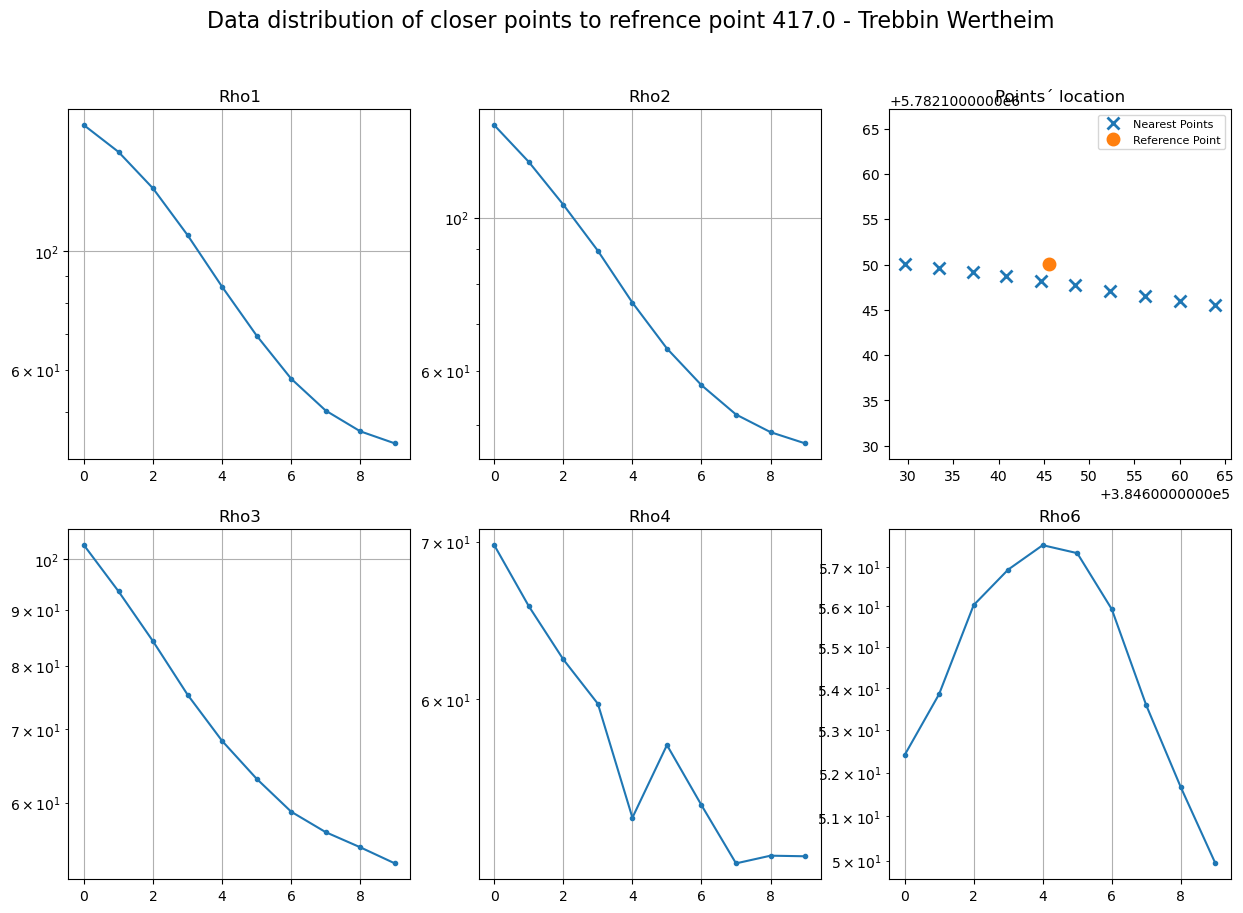

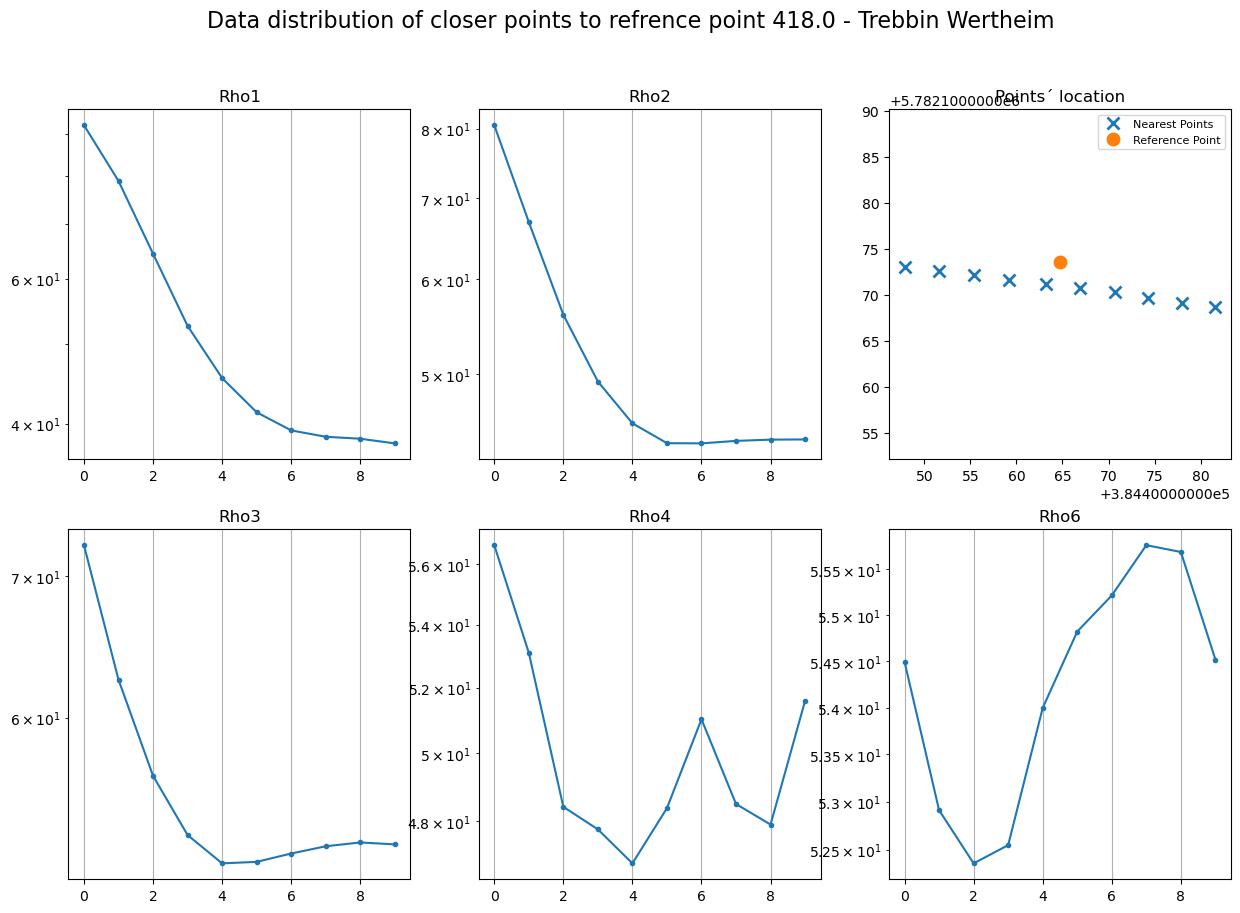

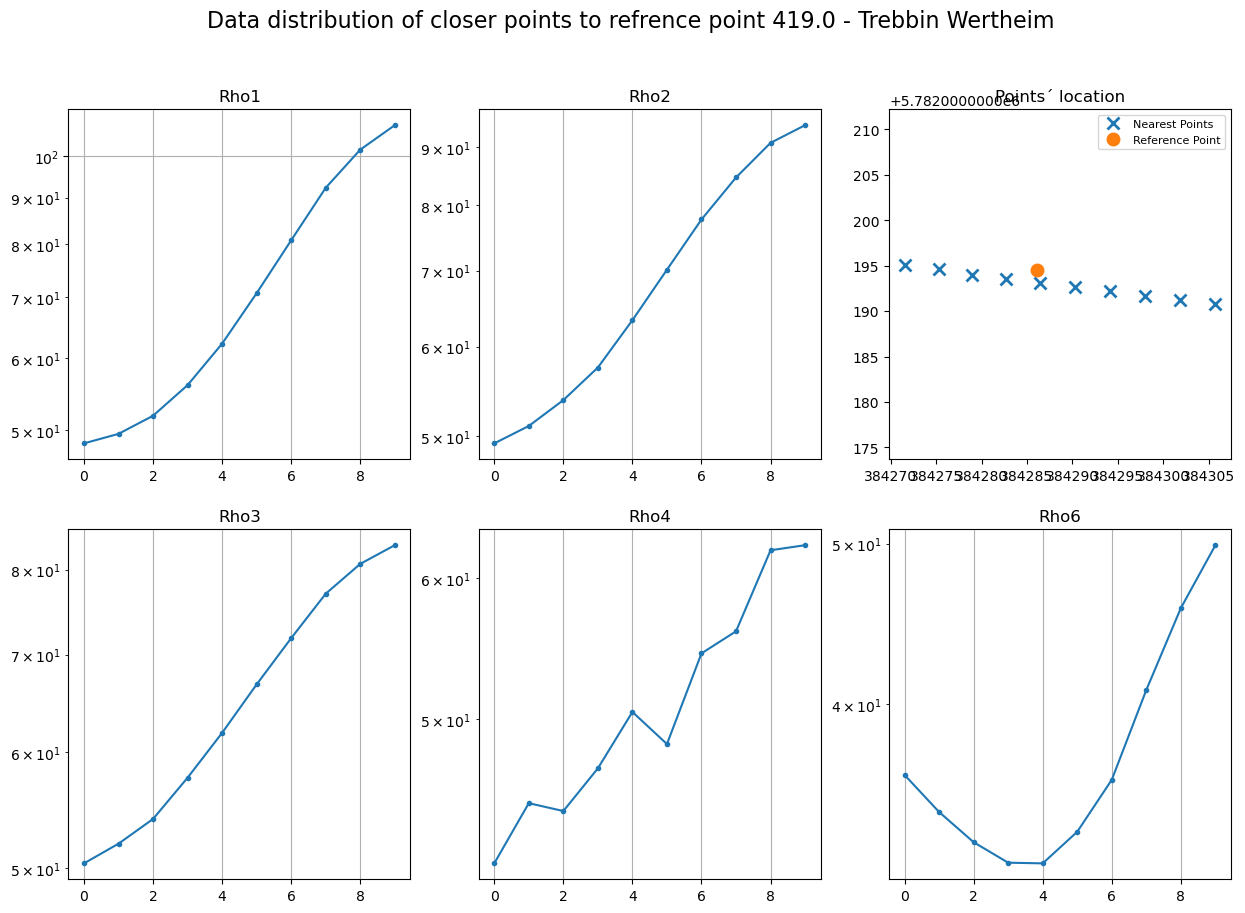

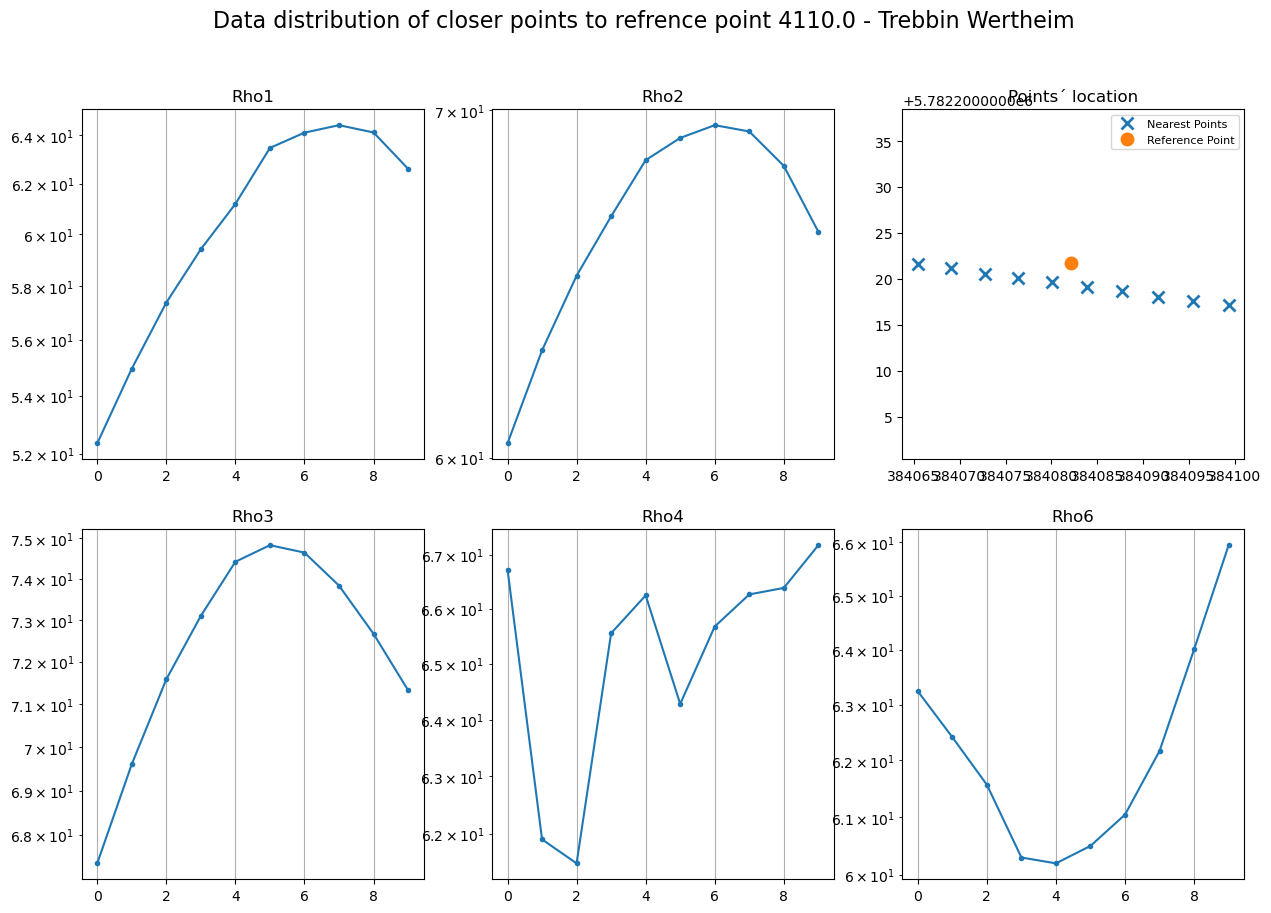

In [10]:
with PdfPages(f'{farmName} DataDistNearestPoints.pdf') as pdf:
    for i , point in RefPoints.iterrows():
        array = data
        dist = np.sqrt((array[:,0]-point['E'])**2+(array[:,1]-point['N'])**2)

        # nearestArray = np.nonzero(dist<distToRef)[0] # return indices of the elements that are non-zero
        
        dist_index = np.argmin(dist)
        nearestArray = np.arange(dist_index-5, dist_index+5)
        dataNearest = data[nearestArray]   # data of individual closest points
        
        fig, ((ax1,ax2,ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
        ax1.semilogy(Rho1[nearestArray], marker='.', label='Rho1')
        ax1.set_title('Rho1')
        ax1.grid()
        fig.suptitle(f'Data distribution of closer points to refrence point {point[0]} - {farmName}', fontsize=16)

        ax2.semilogy(Rho2[nearestArray], linestyle=None, marker='.', label='Rho2')
        ax2.set_title('Rho2')
        ax2.grid()
        
        ax3.plot(Eutm[nearestArray], Nutm[nearestArray], "x", markersize=8, mew=2, label='Nearest Points')
        ax3.plot(point[1], point[2], "o", markersize=8, mew=2, label='Reference Point')
        ax3.axis("equal")
        ax3.set_title('Points´ location')
        ax3.legend(prop={'size': 8})
        
        ax4.semilogy(Rho3[nearestArray], linestyle=None, marker='.', label='Rho3')
        ax4.set_title('Rho3')
        ax4.grid()
        
        ax5.semilogy(Rho4[nearestArray], linestyle=None, marker='.', label='Rho4')
        ax5.set_title('Rho4')
        ax5.grid()
                      
        ax6.semilogy(Rho6[nearestArray], linestyle=None, marker='.', label='Rho6')
        ax6.set_title('Rho6')
        ax6.grid()
            
        plt.savefig(pdf, format='pdf') 
# %%   

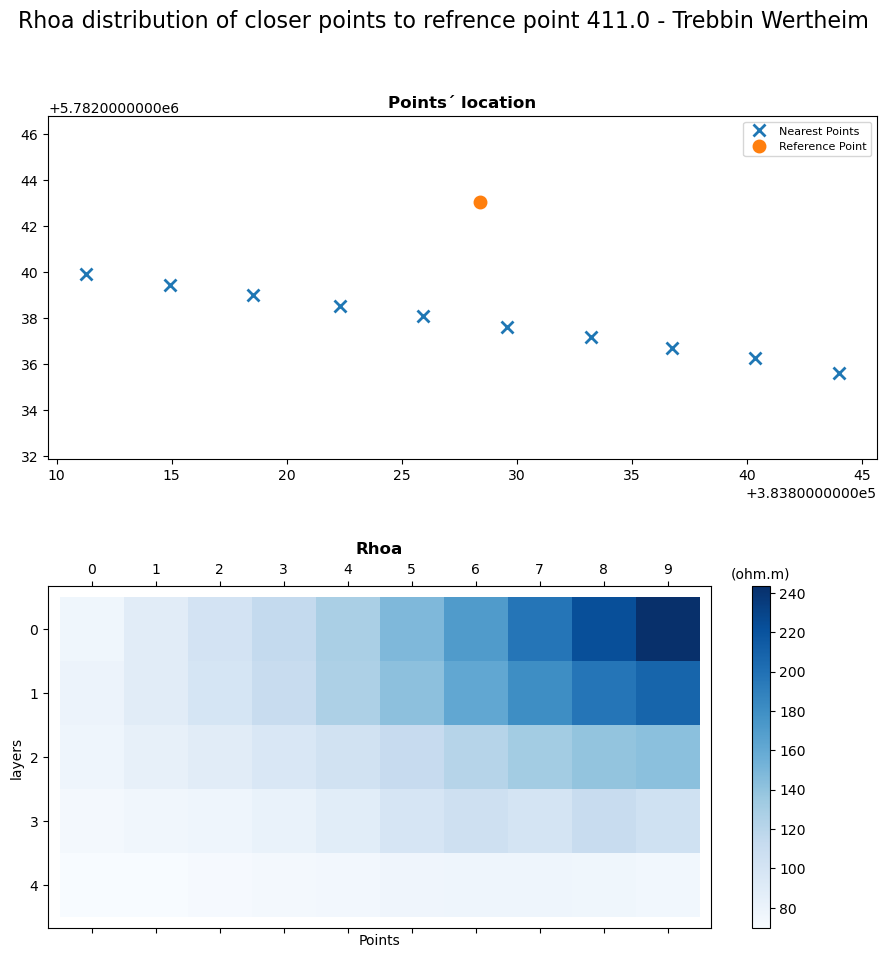

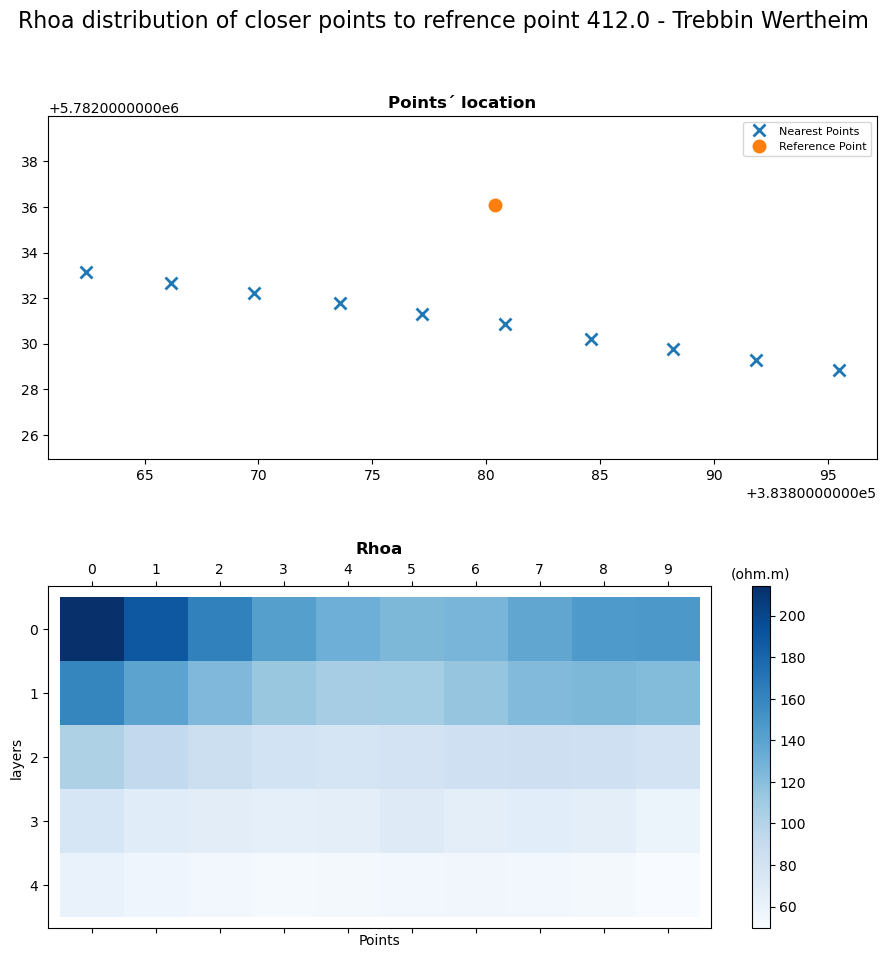

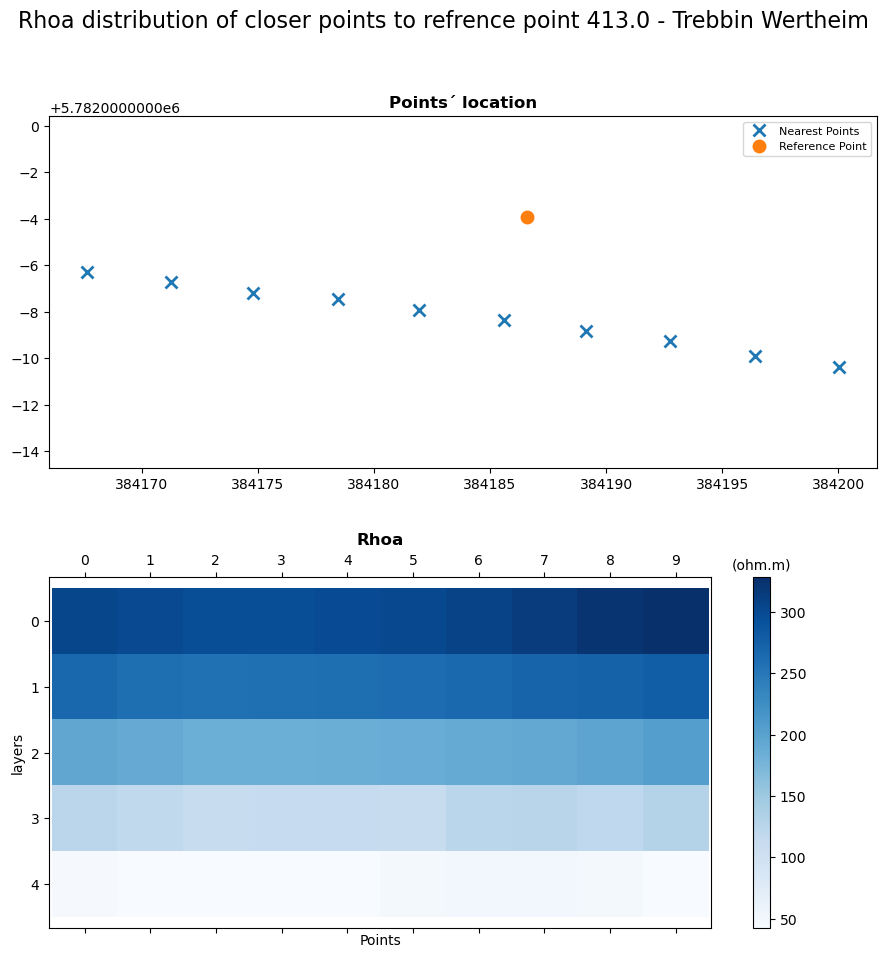

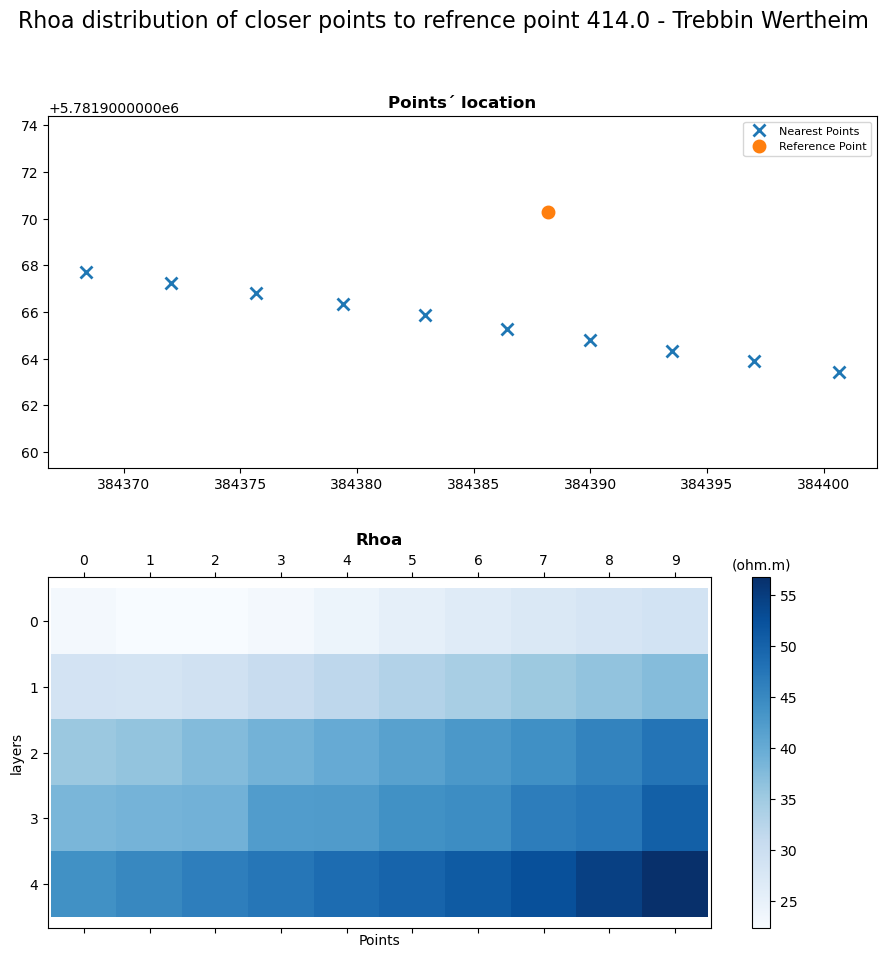

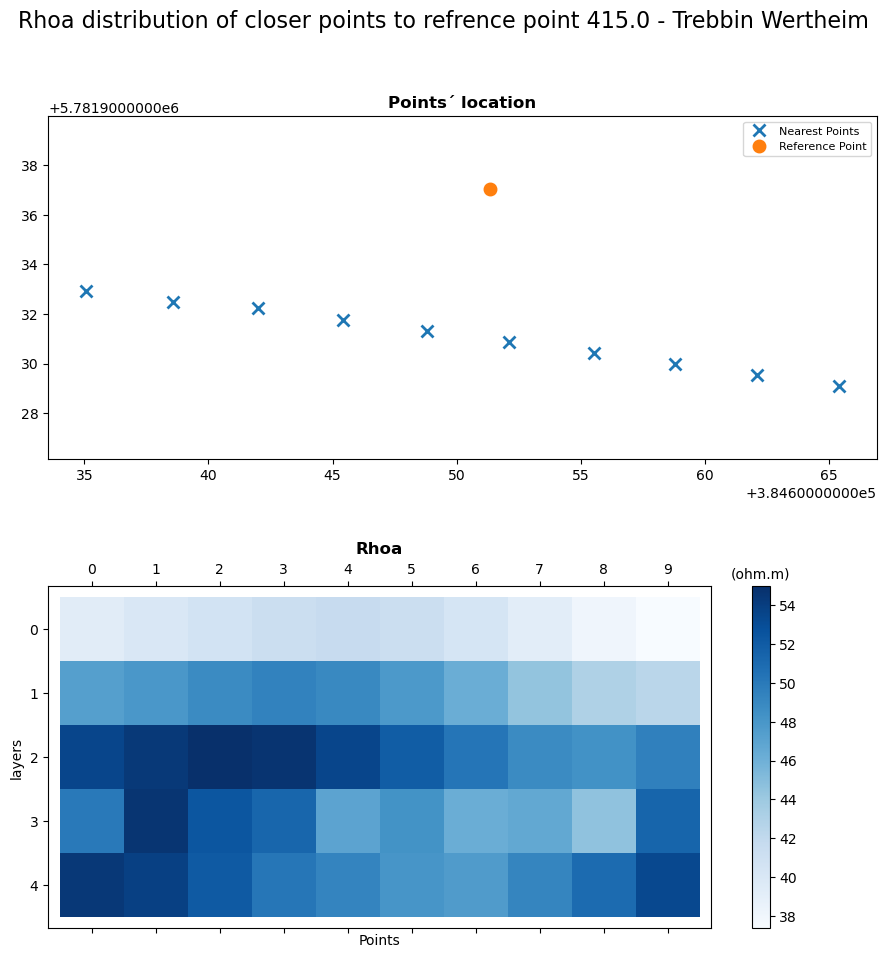

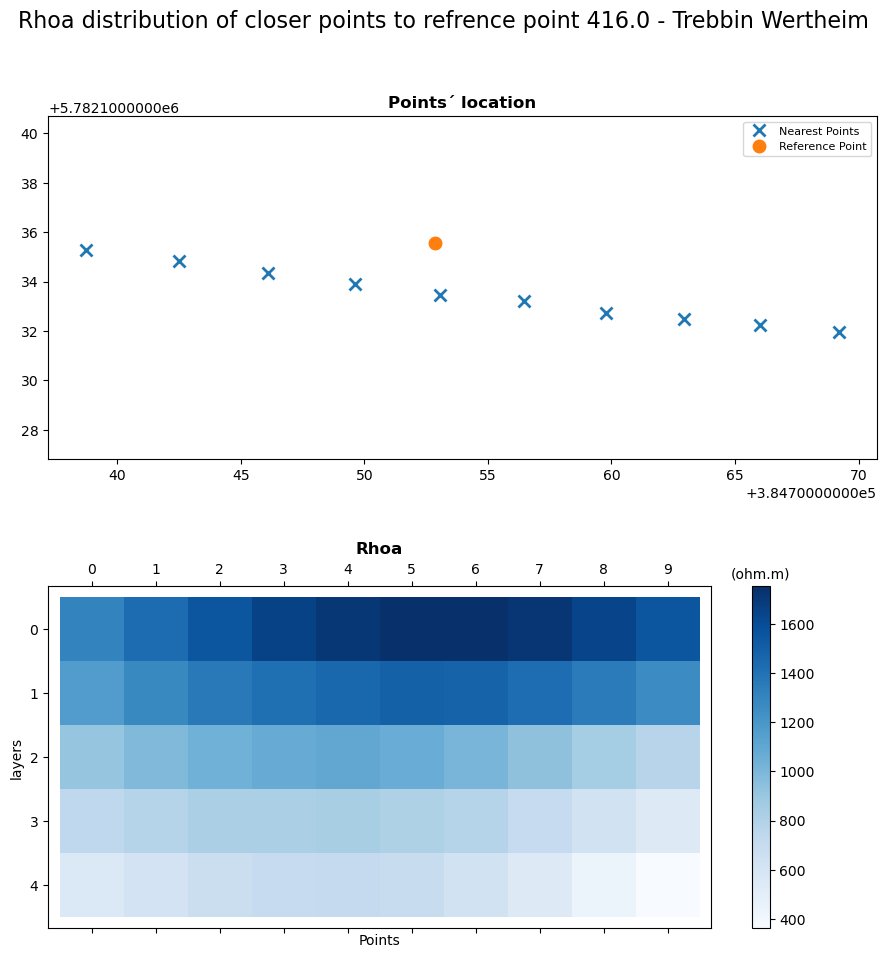

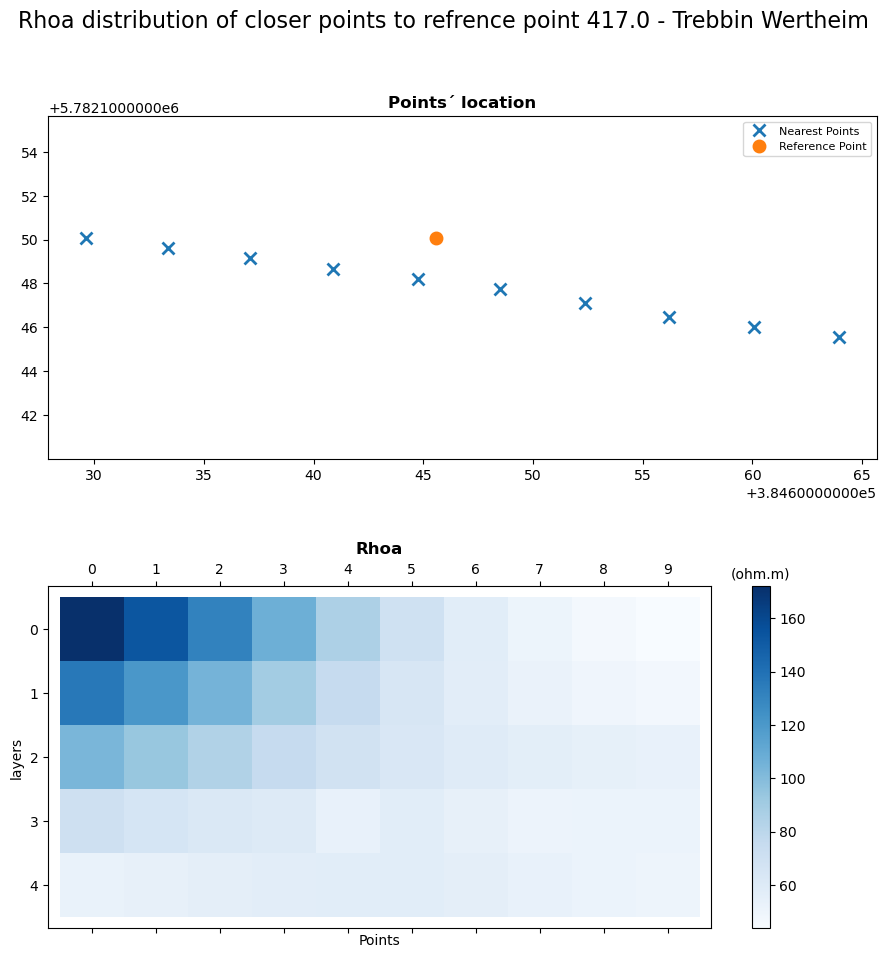

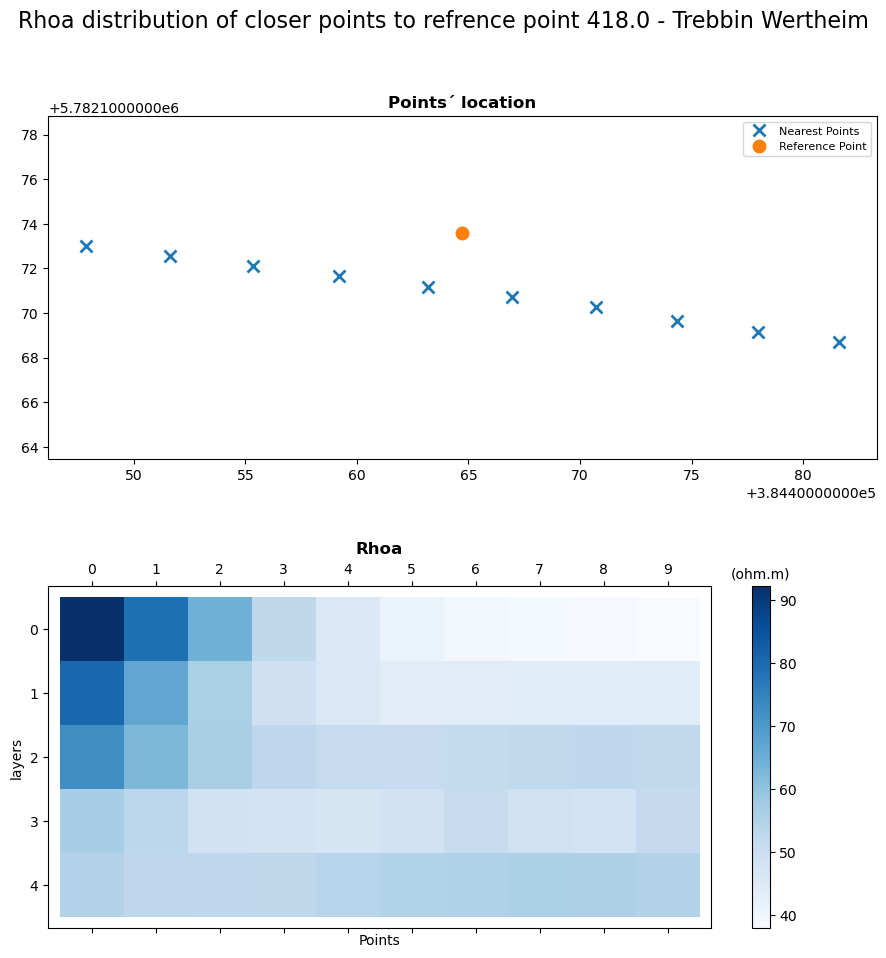

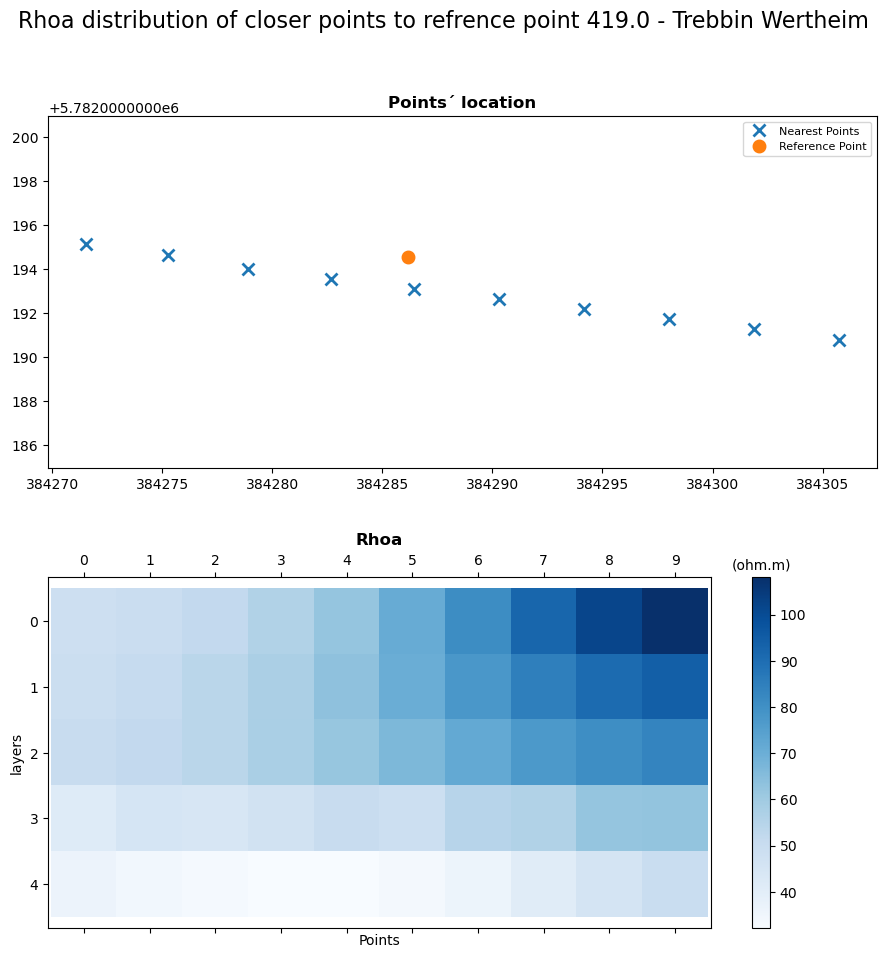

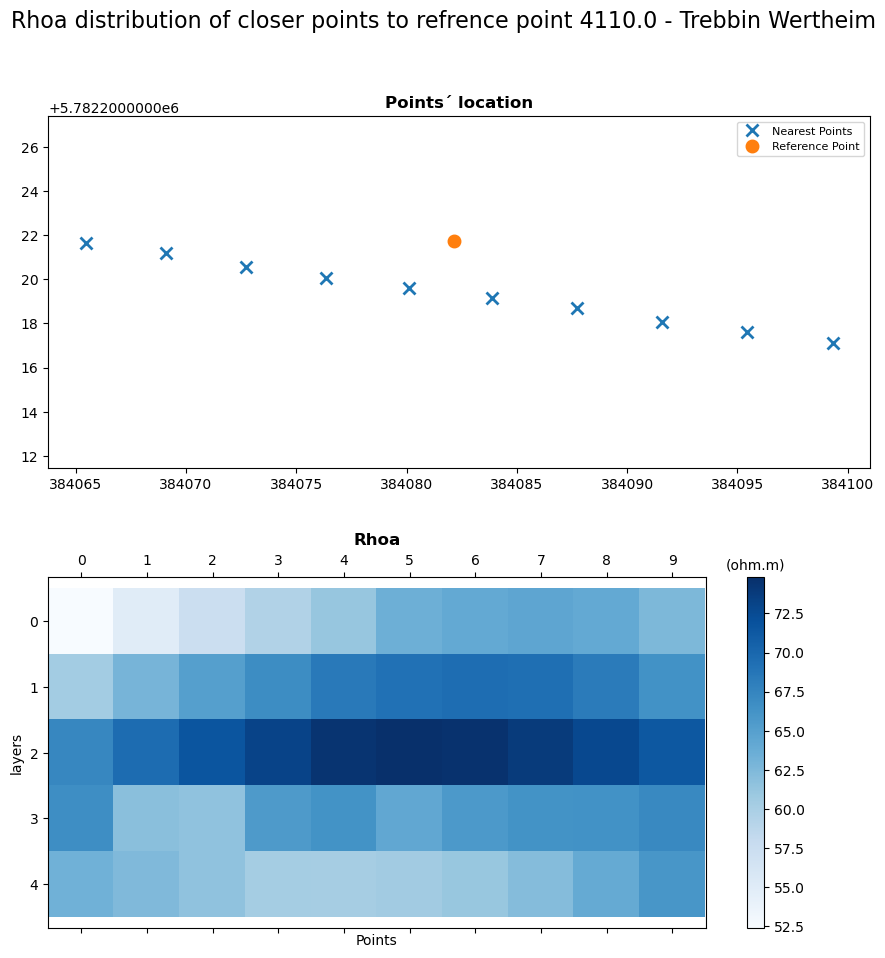

In [11]:
with PdfPages(f'{farmName} RhoaDistNearestPoints.pdf') as pdf:
    for i , point in RefPoints.iterrows():
        array = data
        dist = np.sqrt((array[:,0]-point['E'])**2+(array[:,1]-point['N'])**2)   
        dist_index = np.argmin(dist)
        nearestArray = np.arange(dist_index-5, dist_index+5)
        dataNearest = data[nearestArray]   # data of individual closest points
        
        fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(9.5, 10))
        fig.suptitle(f'Rhoa distribution of closer points to refrence point {point[0]} - {farmName}', fontsize=16)
        
        ax1.plot(Eutm[nearestArray], Nutm[nearestArray], "x", markersize=8, mew=2, label='Nearest Points')
        ax1.plot(point[1], point[2], "o", markersize=8, mew=2, label='Reference Point')
        ax1.axis("equal")
        ax1.set_title('Points´ location', fontweight='bold')
        ax1.legend(prop={'size': 8})
        
        matrixRho = np.vstack([Rho1[nearestArray],Rho2[nearestArray],Rho3[nearestArray],Rho4[nearestArray],Rho6[nearestArray]])
        mat=ax2.matshow(matrixRho, cmap=plt.cm.Blues, vmin=np.min(matrixRho), vmax=np.max(matrixRho))
        ax2.axis("equal")
        ax2.set_title('Rhoa' , fontweight='bold')
        clb = plt.colorbar(mat)
        # clb = fig.colorbar()
        clb.ax.set_title('(ohm.m)',fontsize=10)
        plt.xlabel('Points', fontsize=10)
        plt.ylabel('layers', fontsize=10)
        plt.xticks(ticks=np.arange(len(matrixRho[0])))
        plt.yticks(ticks=np.arange(len(matrixRho)))
        plt.xlim(0,9)
               
        fig.tight_layout(pad=3.0)
        plt.savefig(pdf, format='pdf')

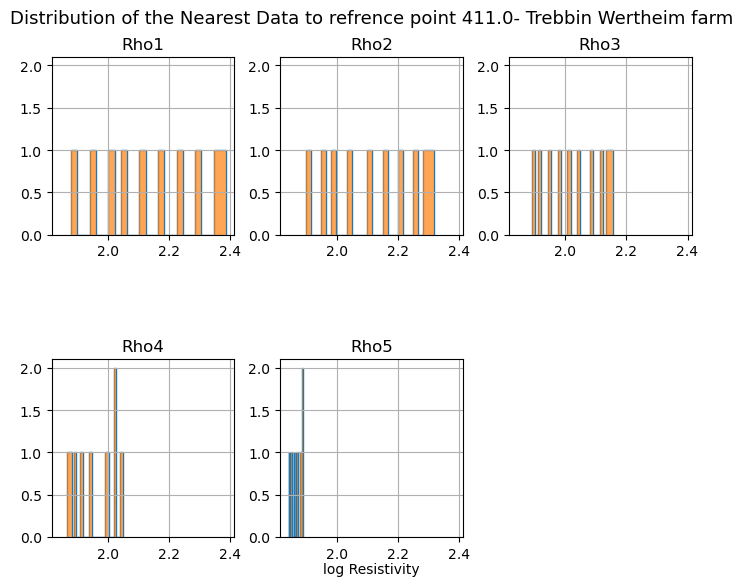

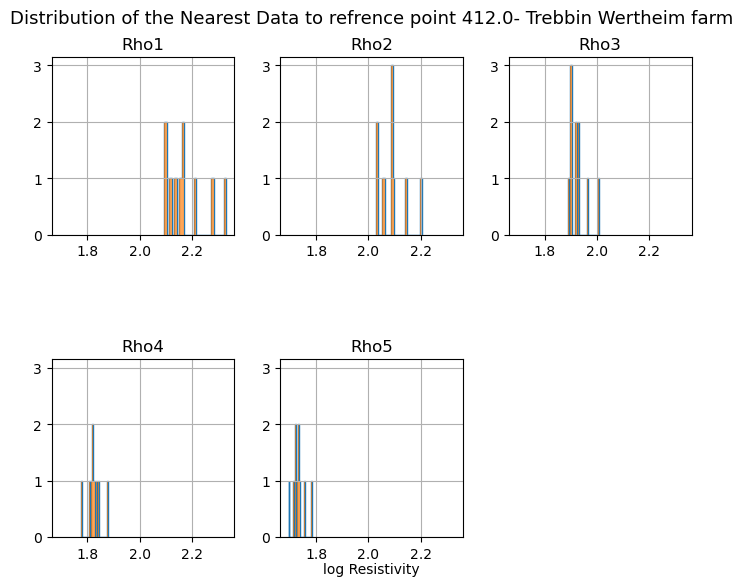

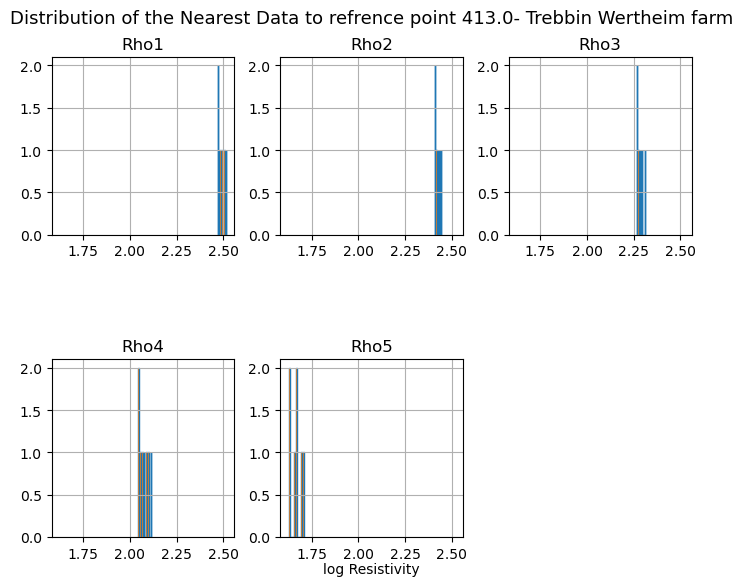

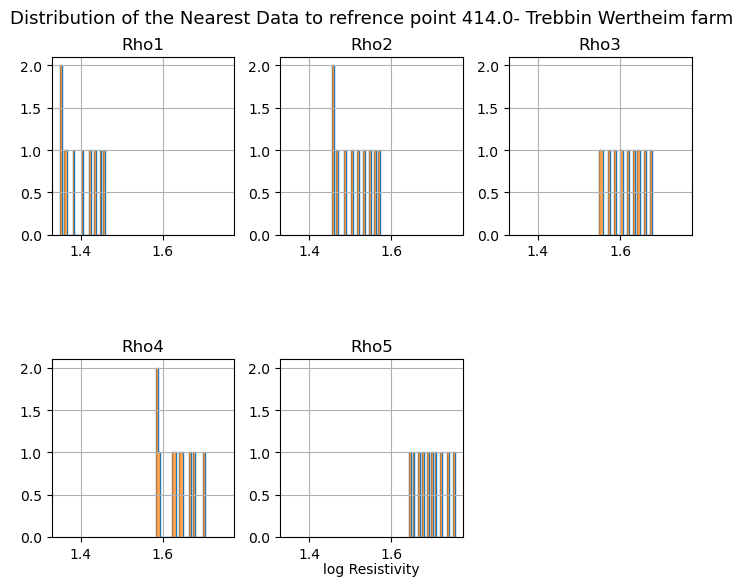

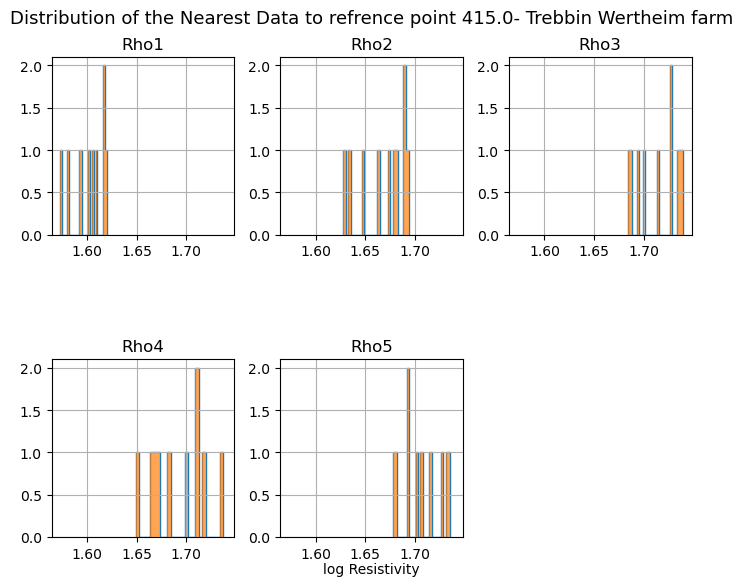

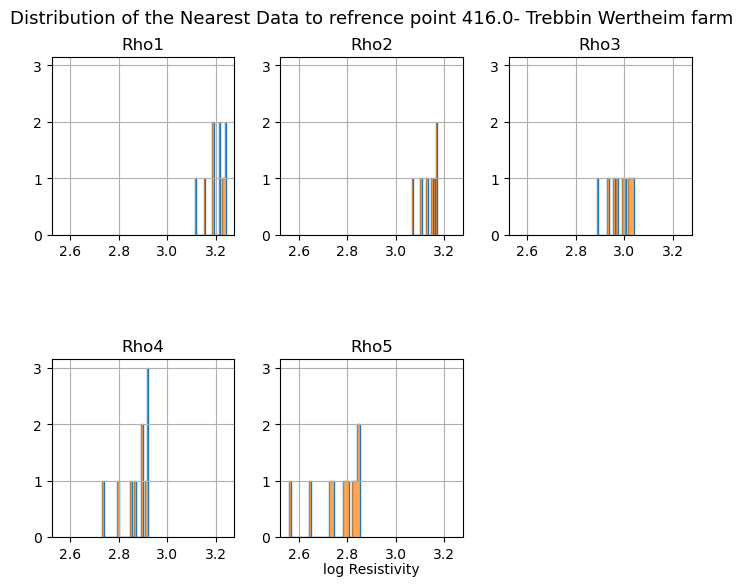

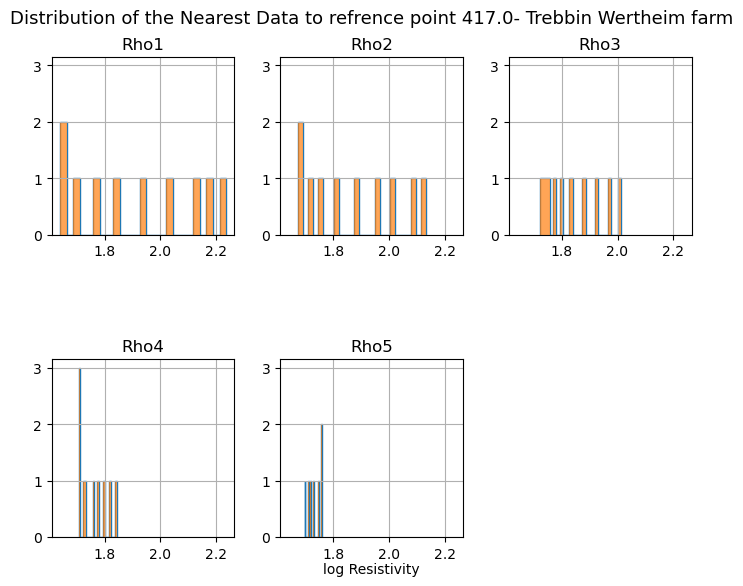

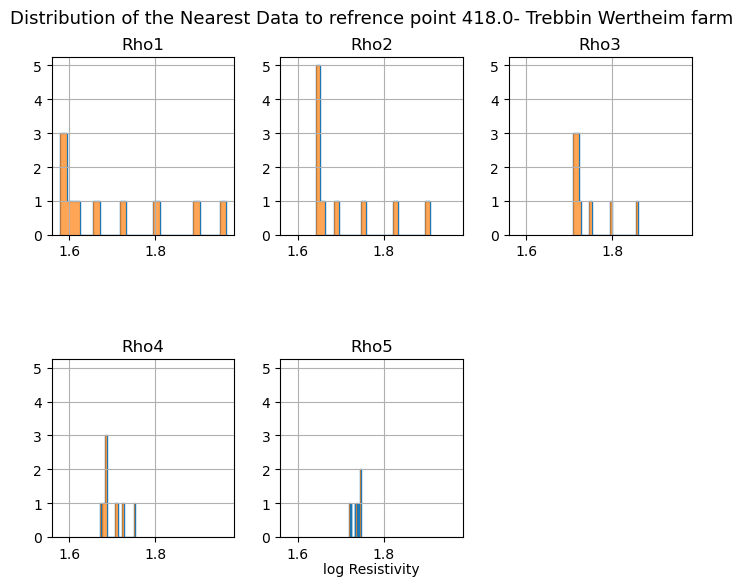

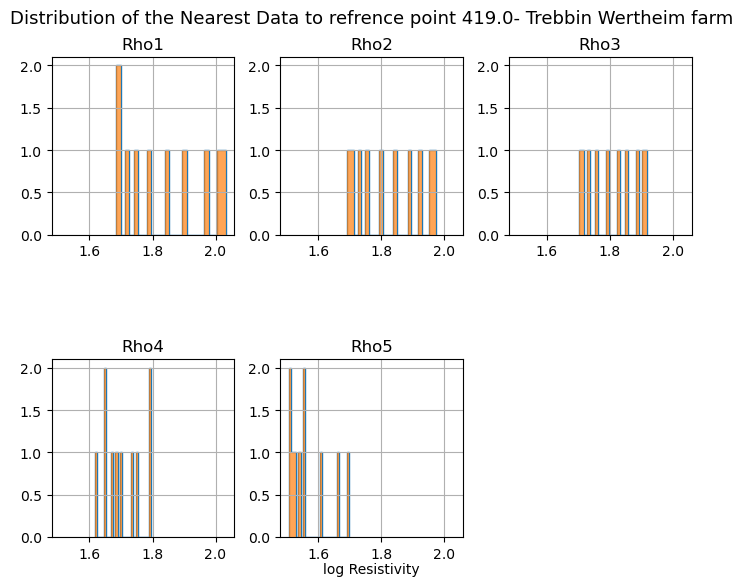

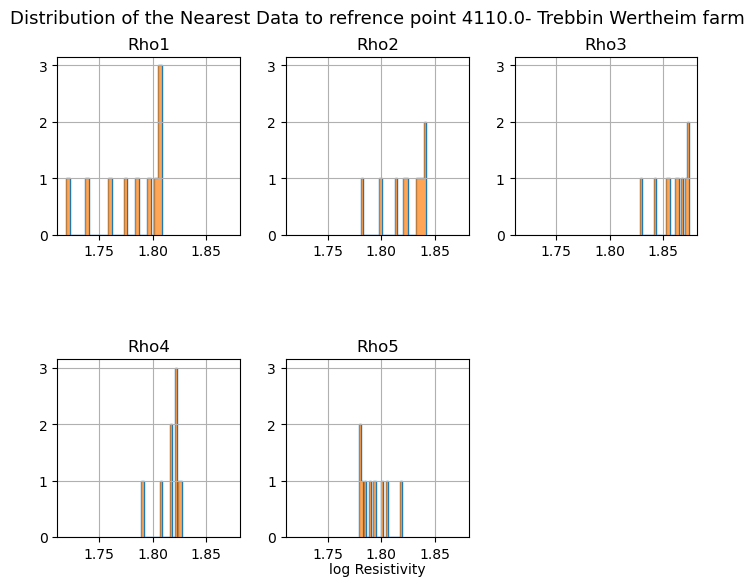

In [12]:
with PdfPages(f'{farmName} DataHistogramNearestPoints.pdf') as pdf:
    for i , point in RefPoints.iterrows():
        array = data
        dist = np.sqrt((array[:,0]-point['E'])**2+(array[:,1]-point['N'])**2)
        # nearestArray = np.nonzero(dist<distToRef)[0] # return indices of the elements that are non-zero
        dist_idx = np.argmin(dist)
        nearestArrays = np.arange(dist_idx-5, dist_idx+5)
        Data_NearestPoints = np.column_stack(((Eutm[nearestArrays]), (Nutm[nearestArrays]), \
                                  (Rho1[nearestArrays]), (Rho2[nearestArrays]), \
                                  (Rho3[nearestArrays]), (Rho4[nearestArrays]), \
                                  (Rho6[nearestArrays]), 
                                  (Gamma[nearestArrays]))) 
          
        Rho_Nearest = Data_NearestPoints[:, 2:7] # Rho of individual closest points
        num_bins = 25
        fig=plt.figure(figsize=(8, 6))
        fig.text(0.5, 0.04, 'log Resistivity', ha='center')
        fig.text(0.04, 0.5, '', va='center', rotation='vertical')
        c = 1  # initialize plot counter
        for cols in range(Rho_Nearest.shape[1]):
            ### plot histogram
            Rho_i = cols+1
            Rhoi =Rho_Nearest[:,cols]
            # print(f'mean Rho{Rho_i} = ', np.round(np.mean(Rhoi),2),  f' \ std Rho{Rho_i} = ', np.round(np.std(Rhoi),2))
            ax1 = plt.subplot(2, 3, 1)
            ax2 = plt.subplot(2, 3, c, sharex=ax1, sharey=ax1)
            counts, bins = np.histogram(np.log10(Rhoi), bins=num_bins)
            ax3 = plt.stairs(counts, bins)
            ax4 = plt.hist(bins[:-1], bins, weights=counts, alpha=0.7)
            plt.suptitle(f'Distribution of the Nearest Data to refrence point {point[0]}- {farmName} farm', fontsize=13, y=0.98)
            plt.title(f'Rho{Rho_i}', fontsize=12)
            # plt.xlabel('log Resistivity')
            plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.25, hspace=0.7)
            plt.grid()
            c=c+1
           
        plt.savefig(pdf, format='pdf') 

exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   372.57
Sill:              0.79
Nugget:            0.00
        


C:\Users\Goldansaz\anaconda3\envs\pg\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   395.44
Sill:              0.61
Nugget:            0.00
        


C:\Users\Goldansaz\anaconda3\envs\pg\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   437.90
Sill:              0.44
Nugget:            0.00
        


C:\Users\Goldansaz\anaconda3\envs\pg\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   500.00
Sill:              0.46
Nugget:            0.00
        


C:\Users\Goldansaz\anaconda3\envs\pg\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


exponential Variogram
---------------------
Estimator:         matheron
Effective Range:   500.00
Sill:              0.50
Nugget:            0.00
        


C:\Users\Goldansaz\anaconda3\envs\pg\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


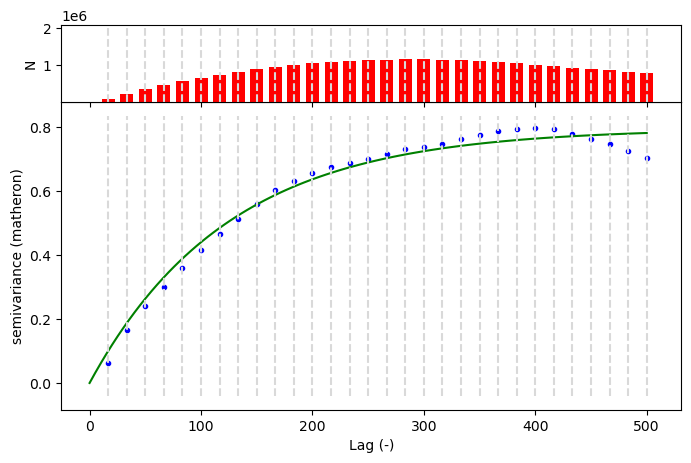

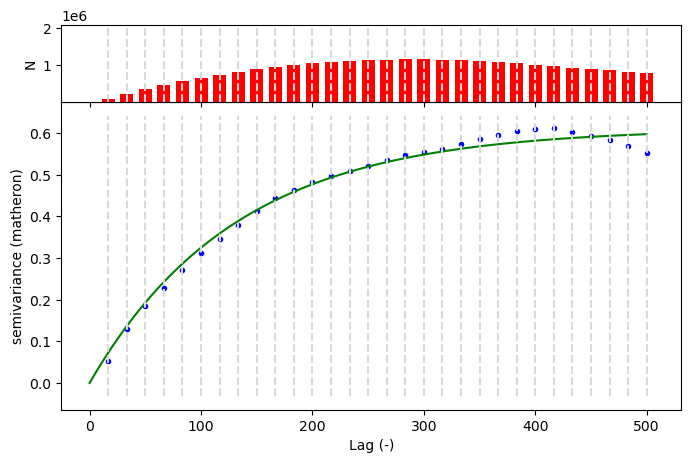

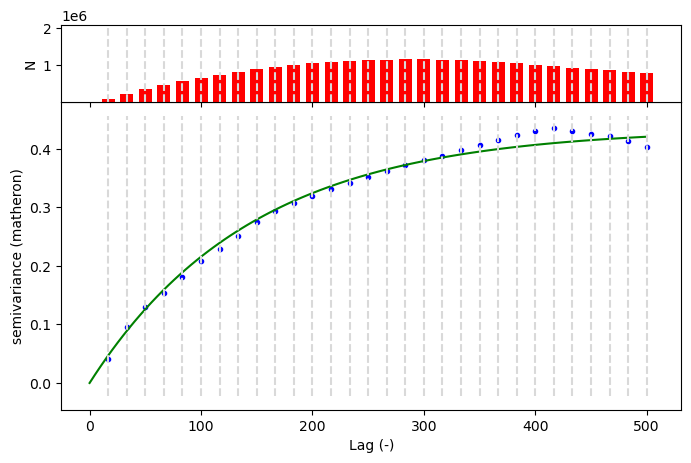

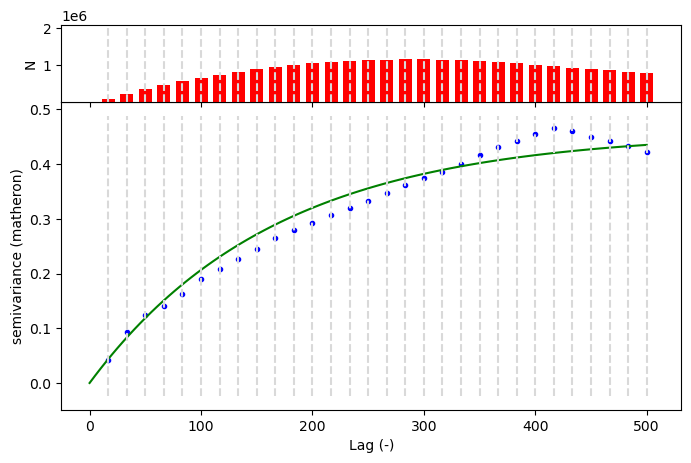

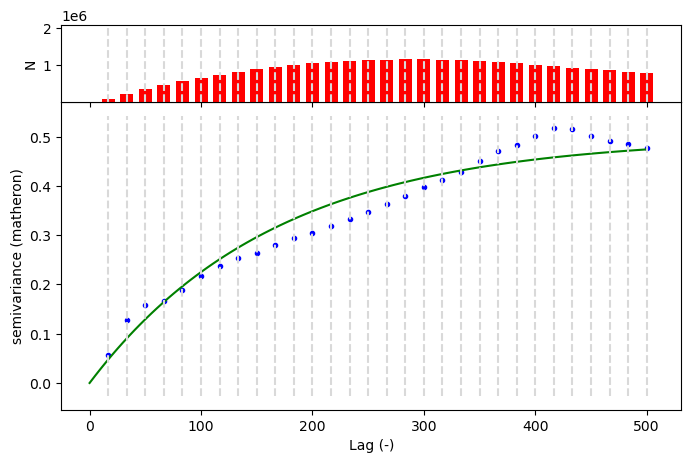

In [13]:
"""Experimental variograms."""
with PdfPages(f'{farmName}_variograms.pdf') as pdf:
    
    Rho = np.column_stack((Rho1, Rho2, Rho3, Rho4, Rho6))
    for rho in range(Rho.shape[1]):
        rho_i = rho+1
        rhoi =Rho[:,rho]    
        coords = np.column_stack((Eutm, Nutm))
        V = skg.Variogram(coords, np.log(rhoi),
                          n_lags=30, maxlag=500, model="exponential")
        print(V)
        fig = V.plot()
        
        plt.savefig(pdf, format='pdf') 

In [ ]:
Now we are ready to do the inversion by importing required libraries:

In [1]:
import numpy as np
import pygimli as pg
from pygimli.frameworks import Modelling, Inversion
from pygimli.viewer.mpl import drawModel1D
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# %% import data

# farmName = 'Brodowin Hoben'

# farmName = 'Beerfelde Banane'

farmName = 'Trebbin Wertheim'

refPoints = pd.read_csv(f'{farmName} farm_refPoints.csv', delimiter=';')
refName = refPoints['Name'].astype(int) # refPoint names
meanNearestPoints = np.loadtxt(f'{farmName}-meanNearestPoints.csv', delimiter=';')
data = np.loadtxt(f'{farmName} farm_data.csv', delimiter=';')
nearestArray = pd.read_csv(f'{farmName}-nearestArray.csv', delimiter=',') # data of individual closest points

In [3]:
# %% Forward Operator and response function
"""VES inversion."""

class VESRhoModelling(Modelling):
    """Vertical electrical sounding (VES) modelling with fixed layers."""

    def __init__(self, thk, **kwargs):
        super().__init__()
        self.fwd = pg.core.DC1dRhoModelling(thk, **kwargs) # kwargs: am, bm, an, bn
        
        mesh = pg.meshtools.createMesh1D(len(thk)+1)
        # self.clearRegionProperties()
        self.setMesh(mesh)

    def response(self, par):
        """Forward response."""
        return self.fwd.response(par)
    

In [4]:
# %% ABMN, res, thk 
# data space
# amVec = np.arange(1, 6) * 0.5  # Geophilius 1.0 (2013)
# amVec = np.arange(1, 7) * 0.5  # Geophilius 2.0 (2017)
amVec = np.arange(1, 6) * 0.6  # Geophilius 3.0 (2020)
b = 1.0
bmVec = np.sqrt(amVec**2+b**2)

# model space
thk = np.ones(15) * 0.1
nLayer = len(thk) + 1

dataNearestMean = np.column_stack((np.array(refName, dtype = 'int'), meanNearestPoints))

In [5]:
# %% Initialize the DC Forward Modelling Operator
fop = VESRhoModelling(thk, am=amVec, an=bmVec, bm=bmVec, bn=amVec)

#  Error Model
error = np.ones_like(amVec) * 0.03 # used in inversion

26/03/23 - 15:08:33 - pyGIMLi - INFO - Starting inversion.


fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000000187FCAC0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000000187FCE20>
min/max (data): 64.5/72.82
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/03/23 - 15:08:34 - pyGIMLi - INFO - Starting inversion.


chi² = 0.28 (dPhi = 88.44%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.28)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000000187FCE20>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000000187FCEE0>
min/max (data): 69.45/79.12
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/03/23 - 15:08:34 - pyGIMLi - INFO - Starting inversion.


chi² = 0.08 (dPhi = 81.94%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.08)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000000187FCD60>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018853B80>
min/max (data): 70.1/88.94
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/03/23 - 15:08:35 - pyGIMLi - INFO - Starting inversion.


chi² = 0.11 (dPhi = 68.18%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.11)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000000187FCEE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018853EE0>
min/max (data): 71.02/101
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/03/23 - 15:08:36 - pyGIMLi - INFO - Starting inversion.


chi² = 0.17 (dPhi = 41.67%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.17)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000000018853EE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000000187FCF40>
min/max (data): 72.22/114
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/03/23 - 15:08:37 - pyGIMLi - INFO - Starting inversion.


chi² = 0.25 (dPhi = 21.25%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.25)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000000018853F40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000000001885DEE0>
min/max (data): 73.7/128
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... 

26/03/23 - 15:08:37 - pyGIMLi - INFO - Starting inversion.


chi² = 0.51 (dPhi = 23.32%) lam: 20


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.51)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000000187FCF40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018863580>
min/max (data): 76.35/148
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.01 (dPhi = 14.7%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.02 (dPhi = 0.38%) lam: 20.0
----------------------------------------------------------

26/03/23 - 15:08:39 - pyGIMLi - INFO - Starting inversion.


chi² = 1.01 (dPhi = 0.0%) lam: 20.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 2.0%)                  #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000000001885DE80>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018863BE0>
min/max (data): 77.03/170
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.73 (dPhi = 33.75%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.69 (dPhi = 2.07%) lam: 20.0
-----------------------------------------------------------

26/03/23 - 15:08:40 - pyGIMLi - INFO - Starting inversion.


chi² = 1.69 (dPhi = 0.0%) lam: 20.0
################################################################################
#                 Abort criteria reached: dPhi = 0.0 (< 2.0%)                  #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000000187FCF40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018863BE0>
min/max (data): 77.3/197
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.02 (dPhi = 75.47%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... 

26/03/23 - 15:08:41 - pyGIMLi - INFO - Starting inversion.


chi² = 0.69 (dPhi = 9.25%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.69)                   #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000000018863B80>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018868220>
min/max (data): 76.07/222
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 2.23 (dPhi = 80.89%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.56 (dPhi = 12.03%) lam: 20.0
-------------------------------------------------------

26/03/23 - 15:08:43 - pyGIMLi - INFO - Starting inversion.


chi² = 1.57 (dPhi = 0.01%) lam: 20.0
################################################################################
#                 Abort criteria reached: dPhi = 0.01 (< 2.0%)                 #
################################################################################
fop: <__main__.VESRhoModelling object at 0x00000000187866D0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x0000000018868F40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000000018868D00>
min/max (data): 73.74/149
min/max (error): 3%/3%
min/max (start model): 100/100
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 0.39 (dPhi = 32.93%) lam: 10


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.39)                   #
###########################

C:\Users\Goldansaz\AppData\Local\Temp\ipykernel_6304\1973341141.py:43: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[0].set_xlim([0, 3000])


UnboundLocalError: local variable 'plt' referenced before assignment

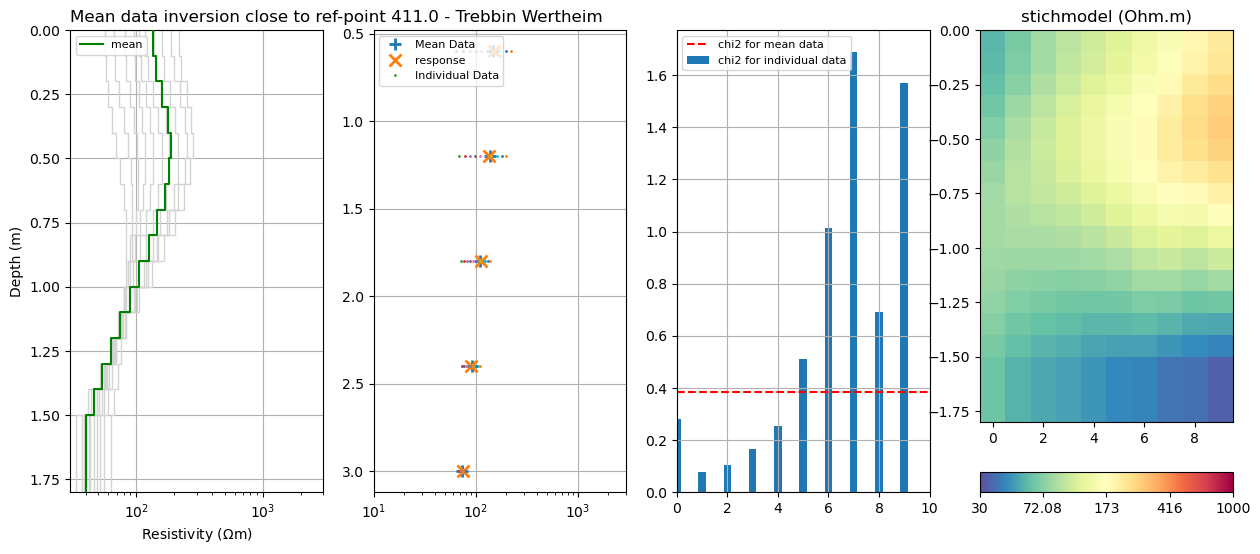

In [6]:
# %% Inversion

with PdfPages(f'{farmName} Inversion_Result_ Mean&Indiv.pdf') as pdf:
# Inversion results for 'Mean' of closest points
    for Data in dataNearestMean:
        # plot individual data
        array = data
        dist = np.sqrt((array[:,0]-Data[1])**2+(array[:,1]-Data[2])**2)
        
        # distToRef = 8
        # nearestArray = np.nonzero(dist<distToRef)[0] # return indices of the elements that are non-zero
        dist_index = np.argmin(dist)
        nearestArray = np.arange(dist_index-5, dist_index+5)
        newamVec = np.tile(amVec, (len(data[nearestArray][:, 3:8]),1))
        fig, ax = pg.plt.subplots(figsize=(15, 6), ncols=4)  # two-column figure

        mydata = data[nearestArray][:, 3:8]
        
        chi2Vec_indiv = []
        chi2Vec_mean = []
        Stmodels = []
        for indivData in mydata:
            inv_indiv = Inversion(fop=fop) # passing the fwd operator in the inversion
            inv_indiv.setRegularization(cType=1) # cType=0:MarquardtLevenberg damping, 10:mixe M.L. & smoothness Constraint
            modelInd = inv_indiv.run(indivData, error, lam=20, startModel=100, verbose=True) # stating model 100 ohm.m, lam: regularization
            Stmodels.append(modelInd)
            drawModel1D(ax[0], thickness=thk, values=modelInd, plot='semilogx', color='lightgray', linewidth=1)
            chi2 = inv_indiv.inv.chi2()
            chi2Vec_indiv.append(chi2)
            # np.savetxt(f'chi2_indiv_{farmName} ref {Data[0]}.csv', chi2Vec_indiv, fmt='%s', delimiter=',')
            
        Rho = np.array(Data[3:8]) 
        inv_mean = Inversion(fop=fop) # passing the fwd operator in the inversion
        inv_mean.setRegularization(cType=1) # cType=0:MarquardtLevenberg damping, 10:mixe M.L. & smoothness Constraint
        modelMean = inv_mean.run(Rho, error, lam=10, startModel=100, verbose=True) # stating model 100 ohm.m, lam: regularization
        # print(modelMean)
        chi2_m = inv_mean.inv.chi2()
        chi2Vec_mean.append(chi2_m)
        # np.savetxt(f'chi2_mean_{farmName} ref {Data[0]}.csv', chi2Vec_mean, fmt='%s', delimiter=',')
                # plot model (inverted and synthetic)                
                
        drawModel1D(ax[0], thickness=thk, values=modelMean, plot='semilogx', color='g', zorder=20, label="mean")
        ax[0].set_xlim([0, 3000])
        ax[0].legend(fontsize=8, loc=2)
        ax[0].set_title(f'Mean data inversion close to ref-point {Data[0]} - {farmName}',  loc='left')

        ax[1].semilogx(Rho, amVec, "+", markersize=9, mew=2, label="Mean Data")
        ax[1].semilogx(inv_mean.response.array(), amVec, "x", mew=2, markersize=8, label="response")
        ax[1].invert_yaxis()
        ax[1].set_xlim([10, 3000])
        ax[1].grid(True) 
        ax[1].semilogx(data[nearestArray][0, 3:8], amVec, ".", markersize=2, label="Individual Data")
        for i in range(1, mydata.shape[0]):
            ax[1].semilogx(mydata[i, :], amVec, ".", markersize=2)
        ax[1].legend(fontsize=8, loc=2)
        
        # ax[2].plot(chi2Vec_indiv, "o", markersize=2, mew=2, label="chi2_data")
        ax[2].bar(range(len(chi2Vec_indiv)), chi2Vec_indiv, width = 0.3,  label="chi2 for individual data")
        # ax[2].plot(chi2Vec_mean, "*", markersize=4, mew=2, label="chi2_mean data")
        ax[2].axhline(chi2Vec_mean, linestyle='--', c='r', label="chi2 for mean data")
        ax[2].grid(True)
        ax[2].set_xlim([0, np.max(len(chi2Vec_indiv))])
        ax[2].legend(fontsize=8, loc=2)

        pg.viewer.mpl.showStitchedModels(Stmodels, ax=ax[3], x=None, cMin=30, cMax=1000, cMap='Spectral_r', thk=thk, logScale=True, title='stichmodel (Ohm.m)' , zMin=0, zMax=0, zLog=False)      

        plt.savefig(pdf, format='pdf') 
